## **Pattern Recognition: Pre-Lab 1 - "Voice recognition with Hidden Markov Models and Recurrent Neural Networks"**

---

### **Course Overview**

This project was developed by our team in the **School of Electrical and Computer Engineering (ECE), NTUA (Semester: Autumn 2025-2026).**
- **Course Name:** Pattern Recognition
- **Instructor:** Alexandros Potamianos
- **Submission Deadline:** 29.10.2025

---

### **Team Overview**

Our team consists of the following members:
- **Peppas Michail-Athanasios** | 03121026
- **Augerinos Panagiotis** | 03121023

---

### **Project Scope**

This assignment focuses on building an **automatic speech recognition (ASR) pipeline for isolated spoken digits (0–9)** using both **probabilistic sequence models** and **neural sequence models**. It now includes work up to **Step 14** of the lab.

The main goals are:

* **a. Audio Feature Extraction and Analysis (Steps 1–4)**  
  - Load and inspect raw speech recordings from the Free Spoken Digit Dataset (FSDD) using `librosa`.  
  - Compute frame-level **MFCC features** (and optionally deltas / delta-deltas).  
  - Compare **MFCCs** and **MFSCs** (Mel filterbank energies) and explain what each feature family captures.  
  - Visualize example utterances and relate the features to the acoustic content.

* **b. Feature Visualization and Dimensionality Reduction (Steps 5–8)**  
  - Compute summary statistics per utterance (e.g. mean and standard deviation of each MFCC coefficient) to get fixed-length vectors.  
  - Visualize feature distributions with histograms / scatter plots.  
  - Apply **PCA** to project features into 2D or 3D, interpret class separability, and measure explained variance.  
  - Train and evaluate classic classifiers (Naive Bayes, SVM, k-NN, Decision Tree, etc.) on these fixed-length vectors, after normalization.

* **c. Sequence Modeling Setup (Step 9)**  
  - Load the full dataset and extract MFCC frame sequences for every utterance.  
  - Respect the dataset’s official split:  
    - A fixed **TEST** set (≈300 samples, ~10% of the 3000 recordings) defined by utterance IDs 0–4.  
    - The remaining ≈2700 samples as the initial training pool.  
  - From that training pool, create a **stratified VALIDATION set (20%)** and the final **TRAIN set (80%)**, preserving digit balance.  
    - Final proportions over the entire dataset are ≈72% TRAIN / ≈18% VAL / 10% TEST.  
  - Fit a `StandardScaler` on TRAIN only and apply it to TRAIN / VAL / TEST.  
    - The printed `mean: [...]` and `std: [...]` are the per-MFCC mean and standard deviation estimated from TRAIN.  
    - Every MFCC frame is normalized
      using these TRAIN-only statistics.  
    - This gives features on comparable scale, stabilizes model training, and prevents validation / test leakage.

* **d. GMM-HMM Acoustic Modeling (Steps 10–13)**  
  - Treat each spoken digit as its own **acoustic class** with its own **Hidden Markov Model (HMM)**.  
  - Use **Gaussian Mixture Models (GMMs)** for HMM emission probabilities, so each state models short-term acoustic behavior of the digit.  
  - Train an HMM per digit on the TRAIN split (frame sequences).  
  - Tune HMM hyperparameters (e.g. number of states, number of Gaussians per state) using the VALIDATION split.  
  - Evaluate recognition accuracy on the TEST split by running Viterbi / likelihood scoring and picking the most likely digit.

* **e. Recurrent Neural Network (RNN / LSTM) Modeling (Step 14)**  
  - Build a sequential neural model (e.g. RNN / LSTM / GRU in PyTorch) that takes the MFCC frame sequence of an utterance and predicts its digit label (0–9).  
  - Train the network on TRAIN, monitor performance on VALIDATION for early stopping or hyperparameter tuning (learning rate, hidden size, etc.).  
  - After tuning, report classification accuracy on the held-out TEST split.  
  - Compare behavior of the neural sequence model against the HMM approach.

* **f. Comparative Evaluation and Discussion (Steps 13–14 conclusions)**  
  - Compare **classical frame-based generative models (GMM-HMM)** vs **discriminative neural sequence models (RNN/LSTM)**.  
  - Discuss robustness across speakers, scaling behavior, data efficiency, and where each model succeeds or fails.  
  - Summarize which pipeline choices mattered most:
    - MFCC parametrization  
    - Normalization strategy  
    - Train / Val / Test protocol  
    - Model architecture and hyperparameters

---

### **Mounting Google Drive**

Before any processing can take place, it is necessary to **mount Google Drive** to access the dataset and supporting files.  
This operation links the Google Drive storage to the **Colab environment**, making files accessible under the path `/content/drive/MyDrive/`.

**Purpose:**  
- Allow direct reading of files (e.g., `pr_lab2_data/digits`) stored in Google Drive.  
- Simplify file handling and path definitions for subsequent steps in the notebook.  

After successful authorization, all project data will be available for loading and analysis.


In [ ]:
# ==============================================================
# Mount Google Drive
# ==============================================================
# This step connects Google Drive to the Colab environment
# and allows access to datasets stored within it.

from google.colab import drive

# Mount the drive at /content/drive
drive.mount('/content/drive')

# Define the dataset path for easy reuse later
import os

# The path containing the data
drive_base = '/content/drive/MyDrive/'
dataset_path = os.path.join(drive_base, 'NTUA-Pattern_Recognition/Lab1/pr_lab2_data')

print(f"Drive mounted successfully. Dataset located at:\n{dataset_path}")


Mounted at /content/drive
Drive mounted successfully. Dataset located at:
/content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data


## **Preparatory Lab - Steps 1-8**

---

### **Step 1 — Praat Analysis (Manual, Included in Report)**

This step is conducted **outside the Colab notebook**, using the **Praat** software.  
It involves visually inspecting and acoustically analyzing two recordings:

- `onetwothree1.wav` (male speaker)  
- `onetwothree8.wav` (female speaker)

**Tasks performed in Praat:**
- Display and compare waveforms and spectrograms.
- Measure the **average pitch** and **first three formants (F1–F3)** for vowels *a*, *u*, *i*.
- Discuss differences between male and female speakers (pitch range, formant spacing).

These measurements, observations, and screenshots are **included in the written report** (not executed in this notebook) as required by the assignment.


### **Step 2 — Isolated-Digit Loader**

#### **Goal**
Discover and load **isolated English digit** recordings (1–9) from `digits/`, convert audio to **mono 16 kHz**, and return exactly **three lists** for the next steps.

---

#### **Public API (used in the code cell)**
- **`parse_digits_wavs_labels_speakers(dataset_root, subdir="digits", target_sr=16000, recursive=True)`**
  - Recursively finds `.wav` files under `<dataset_root>/<subdir>/` and **keeps only names of the following format**:  
    `"<digitword><speaker>.wav"` (e.g., `eight8.wav`).
  - Maps the word to a numeric label **1–9** and uses the numeric suffix as **speaker ID**.
  - Loads each file with `librosa.load(..., sr=16000, mono=True)` to ensure **uniform sampling**.
  - Processes files in **sorted order** for reproducibility.
  - **Returns (in this order):**  
    1) `wavs`: list of `np.ndarray` waveforms  
    2) `y_num`: list of integer labels (1–9)  
    3) `speakers`: list of speaker IDs (strings)

---

#### **Sanity prints**
- A one-line summary: number of parsed files and the sampling rate (16 kHz).
- Counts of returned lists (they must be equal).
- A few `(label, speaker)` pairs and example waveform lengths (in samples).



In [ ]:
# ==============================================================
# Step 2 — Data Parsing (Loading the Speech Corpus)
# ==============================================================

import os
import re
from glob import glob
from typing import List, Tuple, Dict, Optional

import numpy as np
import librosa

# Map digit words → numeric labels for Scheme A ("eight8.wav", etc.)
_WORD_TO_NUM: Dict[str, int] = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9
}

# File name pattern for Scheme A: "<digitword><speaker>.wav"
_SCHEME_A_RE = re.compile(
    r"^(one|two|three|four|five|six|seven|eight|nine)(\d+)\.wav$",
    re.IGNORECASE
)

def parse_digits_wavs_labels_speakers(
    dataset_root: str,
    subdir: str = "digits",
    target_sr: int = 16000,
    recursive: bool = True
) -> Tuple[List[np.ndarray], List[int], List[str]]:
    """
    Load isolated-digit recordings using Scheme A only and return EXACTLY three lists:
      wavs      : List[np.ndarray]  (mono waveforms, resampled to target_sr)
      y_num     : List[int]         (numeric labels 1..9)
      speakers  : List[str]         (speaker IDs as strings)
    """
    search_path = os.path.join(dataset_root, subdir)
    if not os.path.isdir(search_path):
        raise FileNotFoundError(f"Directory not found: {search_path}")

    pattern = "**/*.wav" if recursive else "*.wav"
    files = glob(os.path.join(search_path, pattern), recursive=recursive)
    files.sort()

    wavs: List[np.ndarray] = []
    y_num: List[int] = []
    speakers: List[str] = []

    for f in files:
        fname = os.path.basename(f)
        m: Optional[re.Match] = _SCHEME_A_RE.match(fname)
        if m is None:
            # Ignore anything not matching Scheme A (no Scheme B / no phrase files here)
            continue

        digit_word = m.group(1).lower()
        spk_id     = m.group(2)       # speaker digits after the word
        label      = _WORD_TO_NUM[digit_word]

        # Load mono waveform at the assignment SR (16 kHz)
        wav, _ = librosa.load(f, sr=target_sr, mono=True)
        wavs.append(wav.astype(np.float32))
        y_num.append(int(label))
        speakers.append(str(spk_id))

    print(f"Parsed {len(wavs)} isolated-digit files at {target_sr} Hz "
          f"from: {os.path.join(dataset_root, subdir)}")
    return wavs, y_num, speakers


# --- Example invocation (uses dataset_path defined in the Drive-mount cell) ---
dataset_root = dataset_path
wavs, y_num, speakers = parse_digits_wavs_labels_speakers(dataset_root)
Fs = 16000  # keep SR available for later steps

# Quick sanity printout
print(f"Returned lists: wavs={len(wavs)}, labels={len(y_num)}, speakers={len(speakers)}")
print(f"First 5 (label, speaker): {list(zip(y_num, speakers))[:5]}")
print(f"Example waveform lengths (samples): {[len(w) for w in wavs[:3]]}")



Parsed 133 isolated-digit files at 16000 Hz from: /content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data/digits
Returned lists: wavs=133, labels=133, speakers=133
First 5 (label, speaker): [(8, '1'), (8, '10'), (8, '11'), (8, '12'), (8, '13')]
Example waveform lengths (samples): [11891, 8821, 10485]


### **Step 3 — MFCC, Δ, and ΔΔ Feature Extraction**

#### **Goal**
For each utterance, compute **13 MFCCs** with a **25 ms** analysis window and **10 ms** hop; then compute **Δ** and **ΔΔ** (first and second temporal derivatives). Concatenate per frame to obtain **39-dimensional** features.

---

#### **Functions (What Each Does)**
- **`extract_mfcc_and_deltas(wavs, sr, ...)`**  
  Computes per-frame MFCCs and their temporal derivatives (Δ, ΔΔ), then stacks them to form a 39-D feature sequence per utterance. Returns four aligned lists:
  - `mfcc_seqs` — MFCCs `(T, 13)`  
  - `delta_seqs` — Δ features `(T, 13)`  
  - `delta2_seqs` — ΔΔ features `(T, 13)`  
  - `feats39_seqs` — stacked features `(T, 39)`

- **Example invocation block**  
  Calls the function using the parsed waveforms `wavs` and sampling rate `Fs` (from Step 2), then prints a short summary (number of utterances and example shapes) to verify dimensions.

---

#### **Key Parameters (Summary)**
| **Parameter** | **Type / Default** | **Role** | **Practical Impact** |
|---|---|---|---|
| `wavs` | `List[np.ndarray]` | Waveforms to process. | One feature sequence per utterance. |
| `sr` | `int` (expected **16000**) | Sampling rate (Hz). | Drives ms→samples conversion and time/freq scales. |
| `n_mfcc` | `int = 13` | Number of MFCCs. | Standard for speech; aligns with lab spec. |
| `win_ms` | `int = 25` | Window length (ms). | We **fix the actual analysis window** to 25 ms via `win_length`. |
| `hop_ms` | `int = 10` | Frame step (ms). | Temporal stride; controls number of frames (**T**). |
| `n_mels` | `int = 26` | Mel filterbank channels. | Common baseline front-end for ASR. |
| `center` | `bool = True` | Center frames (with padding). | Matches common librosa defaults. |
| `n_fft` *(derived)* | next power of two ≥ `win_ms·sr/1000` | FFT size. | Speeds STFT while keeping `win_length=25 ms`. |
| `win_length` *(derived)* | `round(win_ms·sr/1000)` | **Actual window size** used by STFT. | Ensures the window is **exactly 25 ms** (lab requirement). |
| `hop_length` *(derived)* | `round(hop_ms·sr/1000)` | Step in samples. | Implements the **10 ms** hop exactly. |

*Defaults (`n_mfcc=13`, `win_ms=25`, `hop_ms=10`, `n_mels=26`) follow the assignment.  
**Important:** We explicitly set `win_length = 25 ms` so the analysis window remains 25 ms even if `n_fft` is a larger power of two.*

---

#### **Output Interpretation**

- `MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.`  
  Confirms lab spec: **13 MFCCs**; **25 ms** window (`win_length=400 @ 16 kHz`); **10 ms** hop (`hop_length=160`); **26** mel filters; FFT uses a power-of-two (e.g., 512) for speed.

- `Utterances processed: 133`  
  All recordings were processed (e.g., **133** total).

- `Example shapes (first utterance): {'mfcc': (T, 13), 'delta': (T, 13), 'delta2': (T, 13), 'stacked_39': (T, 39)}`  
  Per frame we have **13 MFCCs + 13 Δ + 13 ΔΔ = 39** features; time dimension is **T**.

- **Why 39 features?**  
  13 static MFCCs (spectral envelope) + 13 Δ (velocity) + 13 ΔΔ (acceleration) capture spectral shape and short-term dynamics — the standard ASR baseline.



In [ ]:
# ==============================================================
# Step 3 — MFCC, Δ, and ΔΔ Feature Extraction
# --------------------------------------------------------------
# Extracts per-frame speech features:
#   • 13 MFCCs (librosa includes C0 by default)
#   • Δ (first temporal derivatives) and ΔΔ (second temporal derivatives)
# Uses EXACTLY: 25 ms analysis window and 10 ms hop at 16 kHz.
# Concatenates [MFCC | Δ | ΔΔ] → 39-dim features per frame.
# Returns aligned lists of MFCC, Δ, ΔΔ, and stacked (39-D) feature sequences.
# ==============================================================

from typing import List, Tuple
import numpy as np
import librosa

def extract_mfcc_and_deltas(
    wavs: List[np.ndarray],
    sr: int,
    n_mfcc: int = 13,
    win_ms: int = 25,
    hop_ms: int = 10,
    n_mels: int = 26,
    center: bool = True
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Compute MFCCs, Δ (deltas), and ΔΔ (delta-deltas) per utterance and stack them to 39-dim.
    Returns four aligned lists: mfcc, delta, delta2, stacked (T, 3*n_mfcc).

    Implementation notes:
      • We set 'win_length' explicitly to match EXACT 25 ms windows at the given 'sr'.
      • We keep 'n_fft' as a power of two for FFT efficiency, but DO NOT let it change the window duration.
      • librosa.feature.delta expects shape (features, frames), hence the transpose before/after.
    """
    # ---- Frame configuration (in samples) ----
    win_length = int(round((win_ms / 1000.0) * sr))   # 25 ms → 400 at 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))   # 10 ms → 160 at 16 kHz

    # Use a power-of-two FFT size for speed, but preserve exact window duration via 'win_length'.
    n_fft = 1 << (win_length - 1).bit_length()        # e.g., next pow2 ≥ 400 → 512

    mfcc_seqs: List[np.ndarray] = []
    delta_seqs: List[np.ndarray] = []
    delta2_seqs: List[np.ndarray] = []
    feats39_seqs: List[np.ndarray] = []

    for wav in wavs:
        # ---- MFCCs ----
        # librosa returns (n_mfcc, T); we transpose to (T, n_mfcc) so time is the first axis.
        mfcc = librosa.feature.mfcc(
            y=wav,
            sr=sr,
            n_mfcc=n_mfcc,
            n_mels=n_mels,
            n_fft=n_fft,
            win_length=win_length,   # keep the analysis window EXACTLY 25 ms
            hop_length=hop_length,   # keep hop EXACTLY 10 ms
            center=center
        ).T  # (T, n_mfcc)

        # ---- Δ and ΔΔ along time ----
        # librosa.feature.delta expects (features, frames), so transpose to (n_mfcc, T), then back.
        d1 = librosa.feature.delta(mfcc.T, order=1).T   # (T, n_mfcc)
        d2 = librosa.feature.delta(mfcc.T, order=2).T   # (T, n_mfcc)

        # ---- Stack per frame: (T, 13) | (T, 13) | (T, 13) → (T, 39) ----
        f39 = np.hstack([mfcc, d1, d2]).astype(np.float32)

        # Cast to float32 for compactness & consistency
        mfcc_seqs.append(mfcc.astype(np.float32))
        delta_seqs.append(d1.astype(np.float32))
        delta2_seqs.append(d2.astype(np.float32))
        feats39_seqs.append(f39)

    # ---- Log configuration and a simple consistency check ----
    print(
        f"MFCCs/deltas extracted: n_mfcc={n_mfcc}, window={win_ms} ms, hop={hop_ms} ms, "
        f"n_mels={n_mels}, n_fft={n_fft}, win_length={win_length}."
    )
    # Sanity assertion on the first utterance shape
    if feats39_seqs:
        assert feats39_seqs[0].shape[1] == 3 * n_mfcc, "Stacked feature dimension must be 3*n_mfcc."

    return mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs


# ---- Example invocation using parsed waveforms and sampling rate from Step 2 ----
mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

# ---- Sanity output ----
num_utts = len(mfcc_seqs)
first_shapes = {
    "mfcc": None if num_utts == 0 else mfcc_seqs[0].shape,
    "delta": None if num_utts == 0 else delta_seqs[0].shape,
    "delta2": None if num_utts == 0 else delta2_seqs[0].shape,
    "stacked_39": None if num_utts == 0 else feats39_seqs[0].shape,
}
print(f"Utterances processed: {num_utts}")
print(f"Example shapes (first utterance): {first_shapes}")


MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.
Utterances processed: 133
Example shapes (first utterance): {'mfcc': (75, 13), 'delta': (75, 13), 'delta2': (75, 13), 'stacked_39': (75, 39)}


### **Step 4 — MFCC Histograms and MFSC vs MFCC Correlation Analysis**

####**Goal**  
(A) Test how well low-order MFCCs separate digits **n1=6** and **n2=3** using **MFCC₁** and **MFCC₂** histograms.  
(B) Compare feature correlation **before** DCT (MFSC = log-mel energies) and **after** DCT (MFCC) using **two utterances per digit from different speakers**. All features use **25 ms** window and **10 ms** hop at **16 kHz** (exact `win_length`/`hop_length`), with `n_fft` set to the next power-of-two for FFT efficiency.

---

#### **What each function does**

- **`collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, target_digit, coeff_idx)`**  
  Concatenates a **single MFCC coefficient** (e.g., index 0 → MFCC₁, index 1 → MFCC₂) **across all frames and utterances** of `target_digit`.  
  Output: `np.ndarray` of shape `(total_frames_for_digit,)` used to plot per-digit histograms.

- **`choose_k_per_digit(y_num, speakers, digit, k=2)`**  
  Selects up to **k utterance indices** for a given `digit` ensuring **distinct speakers** (greedy; falls back if not enough speakers).  
  Output: list of indices used in the correlation analysis.

- **`compute_mfsc_sequence(wav, sr, n_mels=13, win_ms=25, hop_ms=10, center=True)`**  
  Computes **MFSCs** = **log-mel energies** (pre-DCT) with **exact window/hop**; returns a matrix **(T, 13)** where `T` is the number of frames.

- **`corr_matrix(features_TxD)`**  
  Returns the **D×D Pearson correlation matrix** across feature dimensions for an input matrix **(T, D)**. If `T < 2`, returns `NaN`s.

- **`plot_corr_grid(indices, title_prefix, compute_feats_fn)`**  
  For each utterance index in `indices`, computes features via `compute_feats_fn(idx)`, builds a **correlation matrix**, and plots them in a single row with a **shared colorbar**.

> **Inputs required from previous steps:**  
> `wavs` (audio), `Fs=16000`, `mfcc_seqs` (from Step 3), and the metadata lists `y_num`, `speakers`.

---

#### **A. MFCC₁ and MFCC₂ Histograms (all frames, digits 6 vs 3)**

| **Statistic** | **digit 6** | **digit 3** | **Interpretation** |
|---|---:|---:|---|
| **MFCC₁** (C0/energy-tilt) | mean = **−252.82**, std = **63.04** | mean = **−255.22**, std = **60.99** | Very close → weak separability. |
| **MFCC₂** | mean = **42.21**, std = **23.06** | mean = **59.14**, std = **19.61** | Clear mean shift → better separation. |
| **Frame count** | **1167** | **1149** | Comparable sizes; balanced evidence. |

**Observations.**  
MFCC₁ overlaps heavily (mostly energy/tilt); MFCC₂ is shifted upward for digit 3, offering **useful discriminability**.

---

#### **B. MFSC vs MFCC Correlation (two utterances per digit, different speakers)**

- **MFSC (13-D log-mel energies):** strong **off-diagonal** correlations (adjacent mel bands co-vary) → **redundant** spectral representation.  
- **MFCC (13-D, post-DCT):** correlation matrices are **near-diagonal** with reduced off-diagonal mass → **decorrelated** features.

**Takeaway.**  
The DCT in MFCCs **reduces inter-feature correlation** relative to MFSCs. This favors models that assume independent (or simply-correlated) features (e.g., Gaussian/Naive Bayes) and generally yields a more compact, informative representation.

---

#### **Summary**

- **MFCC₂** adds clear class information for **6 vs 3**; **MFCC₁** alone is weak.
- **MFSCs** exhibit strong internal correlation; **MFCCs** are more decorrelated thanks to the DCT.


Histogram summary (mean, std, count):
digit 6 — MFCC1      | mean=-252.8179 std=63.0411 count=1167
digit 6 — MFCC2      | mean=42.2128 std=23.0640 count=1167
digit 3 — MFCC1      | mean=-255.2218 std=60.9909 count=1149
digit 3 — MFCC2      | mean=59.1361 std=19.6144 count=1149


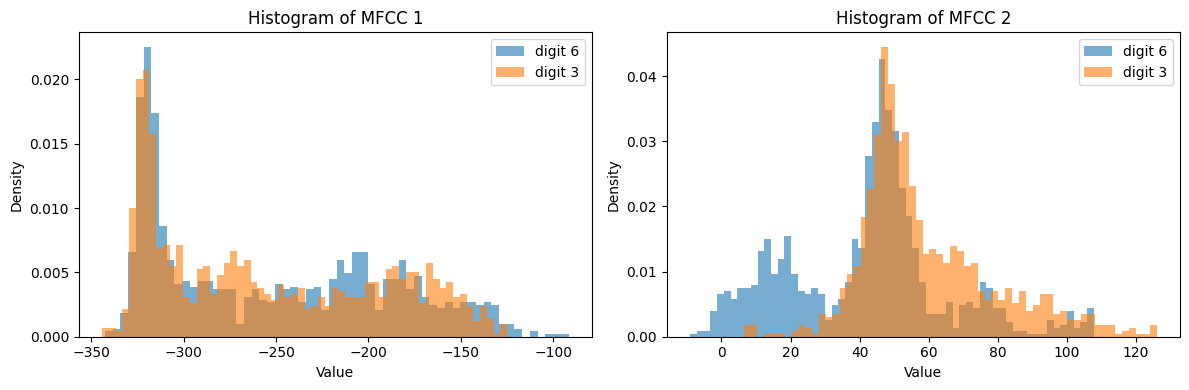


Correlation analysis indices for n1=6: [89, 90] (speakers: ['1', '10'])
Correlation analysis indices for n2=3: [103, 104] (speakers: ['1', '10'])


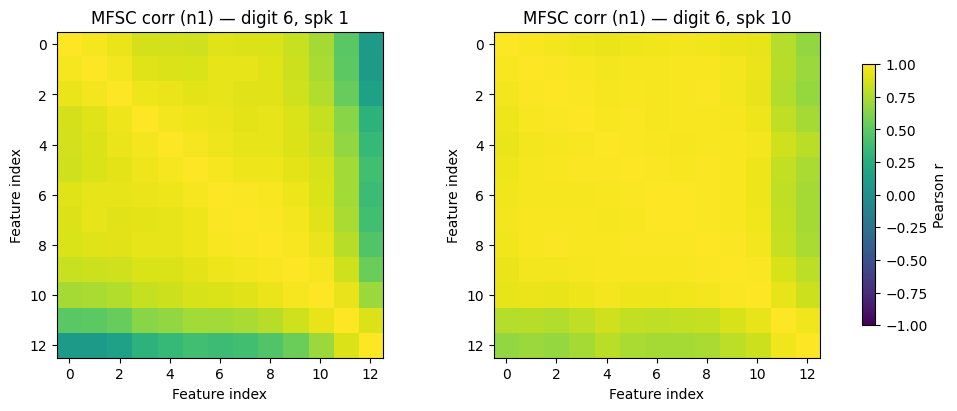

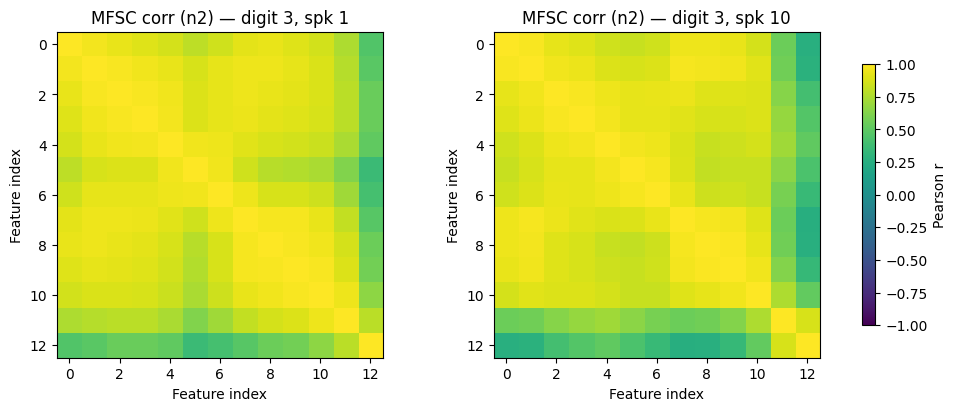

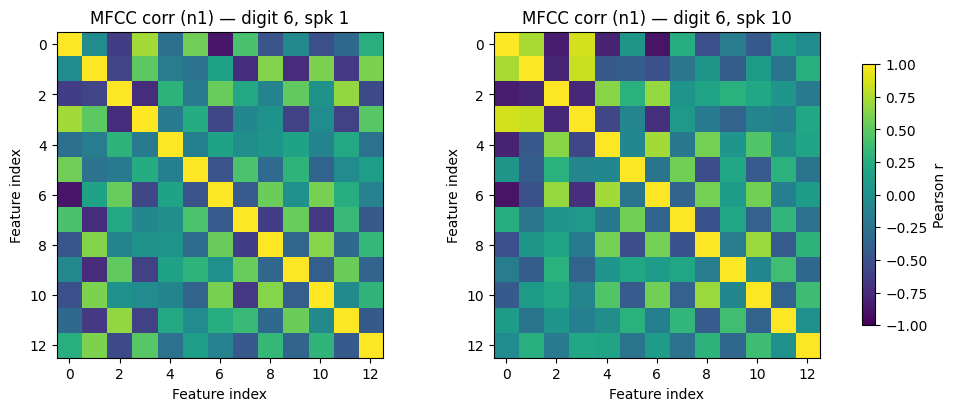

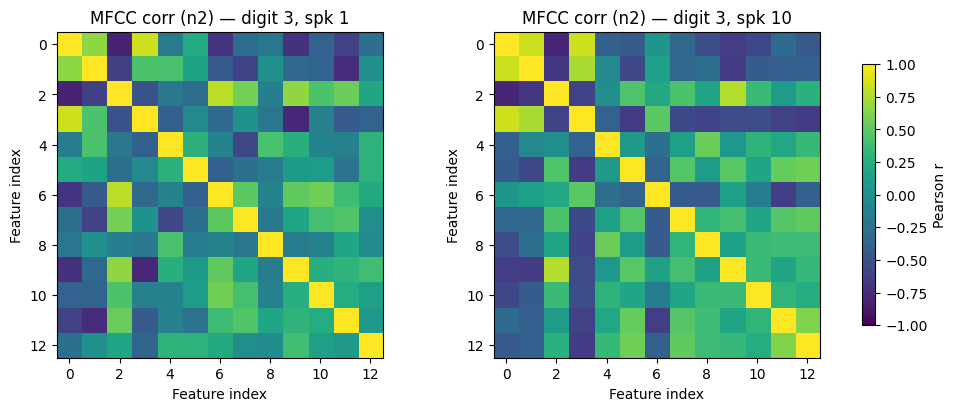

In [ ]:
# ==============================================================
# Step 4 — MFCC histograms (n1=6, n2=3) and MFSC vs MFCC correlation
#            using TWO utterances per digit from DIFFERENT speakers
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa
from typing import List, Tuple

# ---------------- Configuration (from student IDs) ----------------
n1, n2 = 6, 3  # digits chosen from the two student IDs (03121026, 03121023)

# ---------------- Utilities ----------------

def collect_mfcc_coeffs_for_digit(mfcc_seqs: List[np.ndarray],
                                  y_num: List[int],
                                  target_digit: int,
                                  coeff_idx: int) -> np.ndarray:
    """
    Gather one MFCC coefficient across all frames from all utterances of a target digit.
    Returns a 1-D array of values (concatenation across utterances and frames).
    """
    vals = [seq[:, coeff_idx] for seq, y in zip(mfcc_seqs, y_num) if int(y) == int(target_digit)]
    return np.concatenate(vals, axis=0) if vals else np.array([])

def choose_k_per_digit(y_num: List[int], speakers: List[str], digit: int, k: int = 2) -> List[int]:
    """
    Choose up to k utterance indices for the given digit from DISTINCT speakers.
    Falls back gracefully if less diversity is available.
    """
    seen = set()
    idxs = []
    for i, y in enumerate(y_num):
        if int(y) == int(digit):
            spk = speakers[i]
            if spk not in seen:
                idxs.append(i)
                seen.add(spk)
            if len(idxs) == k:
                break
    return idxs

def compute_mfsc_sequence(wav: np.ndarray,
                          sr: int,
                          n_mels: int = 13,
                          win_ms: int = 25,
                          hop_ms: int = 10,
                          center: bool = True) -> np.ndarray:
    """
    Compute MFSCs (Mel Filterbank Spectral Coefficients = log-mel energies, pre-DCT)
    with EXACT 25 ms window and 10 ms hop. Returns (T, n_mels).
    """
    win_length = int(round((win_ms / 1000.0) * sr))    # 25 ms → 400 @ 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))    # 10 ms → 160 @ 16 kHz
    n_fft = 1 << (win_length - 1).bit_length()         # pow2 ≥ 400 → 512

    S = librosa.feature.melspectrogram(
        y=wav, sr=sr,
        n_mels=n_mels,
        n_fft=n_fft, win_length=win_length, hop_length=hop_length,
        center=center, power=2.0
    )  # (n_mels, T)
    logS = np.log(S + 1e-10)
    return logS.T  # (T, n_mels)

def corr_matrix(features_TxD: np.ndarray) -> np.ndarray:
    """
    Compute D×D Pearson correlation across feature dims for a (T, D) matrix.
    If T < 2, returns NaNs.
    """
    if features_TxD.ndim != 2 or features_TxD.shape[0] < 2:
        D = features_TxD.shape[1] if features_TxD.ndim == 2 else 0
        return np.full((D, D), np.nan, dtype=float)
    return np.corrcoef(features_TxD, rowvar=False)

# ---------------- 4A. Histograms for MFCC1 and MFCC2 (n1 vs n2 over ALL utterances) ----------------

# Ensure MFCCs exist (from Step 3). If not, compute minimal MFCCs directly and
# keep EXACT 25/10 ms windowing to match the lab spec.
if 'mfcc_seqs' not in globals():
    win_length = int(round(0.025 * Fs))
    hop_length = int(round(0.010 * Fs))
    n_fft = 1 << (win_length - 1).bit_length()
    mfcc_seqs = [
        librosa.feature.mfcc(
            y=w, sr=Fs, n_mfcc=13,
            n_fft=n_fft, win_length=win_length, hop_length=hop_length
        ).T
        for w in wavs
    ]

mfcc1_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=0)  # MFCC_1
mfcc2_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=1)  # MFCC_2
mfcc1_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=0)
mfcc2_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=1)

# Print quick numeric summaries (helps the discussion in the markdown)
def summarize(name: str, arr: np.ndarray):
    return (name, float(np.mean(arr)), float(np.std(arr)), int(arr.size)) if arr.size else (name, np.nan, np.nan, 0)

summary_stats = [
    summarize(f"digit {n1} — MFCC1", mfcc1_n1),
    summarize(f"digit {n1} — MFCC2", mfcc2_n1),
    summarize(f"digit {n2} — MFCC1", mfcc1_n2),
    summarize(f"digit {n2} — MFCC2", mfcc2_n2),
]
print("Histogram summary (mean, std, count):")
for name, m, s, c in summary_stats:
    print(f"{name:20s} | mean={m:.4f} std={s:.4f} count={c}")

# Plot histograms (overlaid, per coefficient)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(mfcc1_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[0].hist(mfcc1_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[0].set_title("Histogram of MFCC 1")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")
axs[0].legend()

axs[1].hist(mfcc2_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[1].hist(mfcc2_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[1].set_title("Histogram of MFCC 2")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")
axs[1].legend()
plt.tight_layout()
plt.show()

# ---------------- 4B. MFSC vs MFCC correlation (TWO utterances per digit) ----------------

# Pick two utterances per digit with DISTINCT speakers (fallback as needed)
idxs_n1 = choose_k_per_digit(y_num, speakers, digit=n1, k=2)
idxs_n2 = choose_k_per_digit(y_num, speakers, digit=n2, k=2)

print() # empty line
print(f"Correlation analysis indices for n1={n1}: {idxs_n1} (speakers: {[speakers[i] for i in idxs_n1]})")
print(f"Correlation analysis indices for n2={n2}: {idxs_n2} (speakers: {[speakers[i] for i in idxs_n2]})")

# Compute correlation matrices for MFSC and MFCC for each selected utterance
def plot_corr_grid(indices: List[int], title_prefix: str, compute_feats_fn):
    """
    Plot a horizontal grid of correlation matrices (one per utterance index).
    """
    if not indices:
        print(f"Warning: no indices for {title_prefix}.")
        return
    cols = len(indices)
    fig, axs = plt.subplots(1, cols, figsize=(5 * cols, 4), constrained_layout=True)
    if cols == 1:
        axs = [axs]
    last_im = None
    for j, idx in enumerate(indices):
        feats_TxD = compute_feats_fn(idx)   # (T, D)
        C = corr_matrix(feats_TxD)
        last_im = axs[j].imshow(C, vmin=-1, vmax=1, aspect='equal')
        axs[j].set_title(f"{title_prefix} — digit {y_num[idx]}, spk {speakers[idx]}")
        axs[j].set_xlabel("Feature index")
        axs[j].set_ylabel("Feature index")
    fig.colorbar(last_im, ax=axs, shrink=0.8, label="Pearson r")
    plt.show()

# MFSC correlation (13-D, exact 25/10 ms)
plot_corr_grid(
    idxs_n1, "MFSC corr (n1)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)
plot_corr_grid(
    idxs_n2, "MFSC corr (n2)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)

# MFCC correlation (13-D) for the SAME utterances (to visualize DCT decorrelation)
plot_corr_grid(
    idxs_n1, "MFCC corr (n1)", lambda idx: mfcc_seqs[idx]
)
plot_corr_grid(
    idxs_n2, "MFCC corr (n2)", lambda idx: mfcc_seqs[idx]
)


### **Step 5 — Utterance-Level Aggregation and 2D Scatter**

#### **Goal**
Convert each utterance’s frame-level features into a **fixed-length vector** and visualize low-dimensional separability.  
For every utterance, we take the 39-D sequence from Step 3 (**13 MFCC + 13 Δ + 13 ΔΔ**) and compute **mean** and **standard deviation** over time → a **78-D** vector `[μ(39) | σ(39)]`.

---

#### **What the code does**
- Builds `X_stats ∈ ℝ^{N×78}` with labels `y ∈ {1,…,9}` by concatenating per-feature **means** and **stds** across frames.  
- Plots **dimension 0** vs **dimension 1**, i.e., **μ(MFCC₁)** vs **μ(MFCC₂)** (time means of the first two cepstral coefficients).  
  - Recall: MFCC₁ (C0) is largely energy/tilt-related; MFCC₂ reflects coarse spectral slope / formant spacing.

---

#### **How to read the figure**
- **X-axis:** μ(MFCC₁). This tends to vary with global energy/tilt → **weak class separation**.  
- **Y-axis:** μ(MFCC₂). Captures broad spectral shape → typically **more discriminative** than MFCC₁.  
- **Markers/legend:** Each digit (1–9) uses a distinct marker; cluster positions show where that digit’s utterances tend to lie.

---

#### **Observed results (from our plot)**
- **Overall overlap** is substantial using only μ(MFCC₁) and μ(MFCC₂) — expected for such a compact summary.  
- **μ(MFCC₂) separates better**: higher values are frequent for digits like **1** and **7**, whereas **6** often occupies lower μ(MFCC₂).  
- **Speaker/utterance variability** produces visible intra-class spread (both axes), consistent with multi-speaker data.  
- Net: this 2D view provides some intuition (especially from μ(MFCC₂)) but is **not linearly separable** across all digits.

---

#### **Answering the assignment’s intent**
- We produced the required **utterance-level vectors** (mean+std over the 39-D frames → 78-D) and visualized the **first two dimensions** (μ(MFCC₁), μ(MFCC₂)).  
- The figure demonstrates that **MFCC₂** carries **more discriminative information** than **MFCC₁**, while **two statistics alone are insufficient** for clean class separation.  
- This motivates the next steps (PCA to 2D/3D and downstream classifiers) to capture **richer structure** than what the two means alone can provide.


Utterances: 133, Feature dimension: 78 (expected 78)


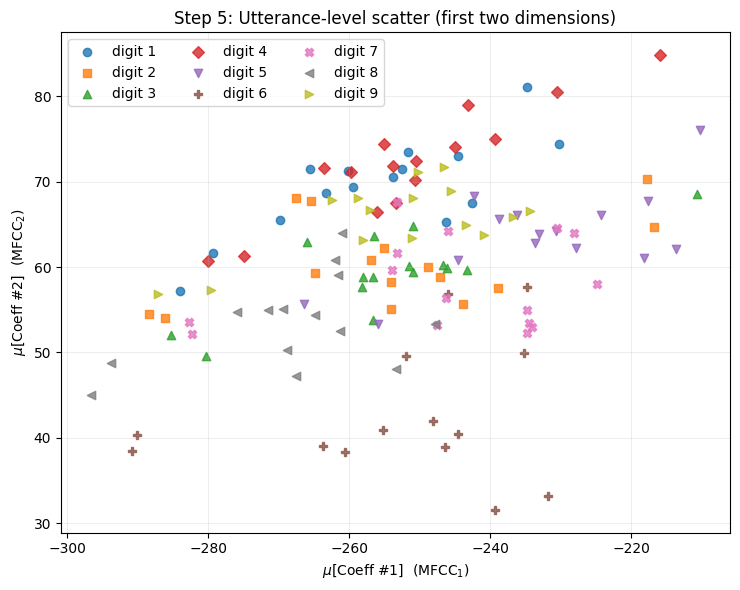

In [ ]:
# ==============================================================
# Step 5 — Utterance-level feature vectors (mean & std) and 2D scatter
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# Ensure frame-level 39-D features exist (from Step 3); otherwise compute them.
if 'feats39_seqs' not in globals():
    mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

def aggregate_mean_std(seqs: List[np.ndarray]) -> np.ndarray:
    """
    Convert a list of frame sequences (T_i x D) to utterance-level vectors.
    For each utterance, compute mean and std over time for each of the D features,
    then concatenate [mean(0..D-1), std(0..D-1)] → (2D,).
    """
    X = []
    for F in seqs:                       # F: (T, D)
        mu = F.mean(axis=0)              # (D,)
        sd = F.std(axis=0, ddof=0)       # (D,)
        X.append(np.hstack([mu, sd]))    # (2D,)
    return np.asarray(X)                  # (N, 2D)

# Build utterance-level dataset: X has 78 dims when D=39
X_stats = aggregate_mean_std(feats39_seqs)   # shape: (N, 78)
y_labels = np.asarray(y_num)                 # integer digit labels 1..9
speakers_arr = np.asarray(speakers)

assert X_stats.shape[0] == y_labels.shape[0], "Mismatch: features and labels must have same N."
print(f"Utterances: {X_stats.shape[0]}, Feature dimension: {X_stats.shape[1]} (expected 78)")

# Scatter of the first two dimensions:
# With stacking order [MFCC(13) | Δ(13) | ΔΔ(13)], dims 0 and 1 correspond to MFCC1_mean and MFCC2_mean.
dims = (0, 1)

digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 distinct markers for digits 1..9
plt.figure(figsize=(7.5, 6))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_stats[sel, dims[0]],
        X_stats[sel, dims[1]],
        label=f"digit {d}",
        alpha=0.8,
        marker=markers[i % len(markers)],
        s=36
    )

plt.xlabel(r"$\mu$[Coeff #1]  (MFCC$_1$)")
plt.ylabel(r"$\mu$[Coeff #2]  (MFCC$_2$)")
plt.title("Step 5: Utterance-level scatter (first two dimensions)")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()


### **Step 6 — PCA Dimensionality Reduction (2D & 3D)**

#### **Goal**
Apply **PCA** to the utterance-level features to obtain **2D** and **3D** visualizations and report the **explained variance** captured by the principal components, as requested in the PDF.

---

#### **Pipeline (what this cell does)**
- **Input:** `X_stats ∈ ℝ^{N×78}` (per-utterance `[μ(39) | σ(39)]` from Step 5) with digit labels `y`.
- **Standardize:** `StandardScaler` (zero mean, unit variance per feature).
- **PCA:** Fit `PCA(n_components=3)` on standardized data → project to **(PC1, PC2)** and **(PC1, PC2, PC3)**.
- **Plots:** 2D and 3D scatters colored/labeled by digit.
- **Report:** Print the **explained variance ratio (EVR)** per component and the **cumulative** EVR for 2D and 3D.

---

#### **What is EVR (Explained Variance Ratio)?**  
For PCA eigenvalues $\{\lambda_k\}$ of the (standardized) data covariance, the EVR of component $k$ is
$
\mathrm{EVR}_k \;=\; \frac{\lambda_k}{\sum_j \lambda_j}.
$
It is the **fraction of total variance** captured by principal component $k$. Across **all** components, EVRs sum to 1 (100%).

---

#### **What is cumulative EVR?**  
For the first $m$ components,
$
\mathrm{CumulativeEVR}(m) \;=\; \sum_{k=1}^{m} \mathrm{EVR}_k,
$
i.e., the **total fraction of variance preserved** by keeping the top $m$ PCs. It’s used to judge how many PCs are needed to retain a desired amount of information.

---

#### **Our run — explained variance**
- EVR per component: **PC1 = 12.54%**, **PC2 = 7.51%**, **PC3 = 6.33%**  
- **Cumulative (2D): 20.06%** | **Cumulative (3D): 26.39%**

#### **How to read the figures.**
- PCA axes are **unsupervised** directions of **maximal variance** in the standardized 78-D space.  
- Clear, tight clusters → stronger class structure; heavy overlap → limited separability by a linear unsupervised projection.

---

#### **Observations (from our plots)**
- **2D (PC1–PC2):** modest grouping tendencies but **substantial overlap** among digits.  
- **3D (PC1–PC3):** small improvement, yet **classes still overlap** notably.  
- Interpretation: **variance is spread across many dimensions**; the top 2–3 PCs capture only ~20–26% and do **not** align perfectly with digit boundaries (expected for unsupervised PCA).

#### **Notes for the report**
- We applied PCA to **2D and 3D**, reported **EVR** and **cumulative EVR**, and discussed that low-dimensional PCA views provide **limited separability**.  
- For **classification** (Step 7), we will use the **full 78-D features** (with train-only scaling), or consider **supervised** projections (e.g., LDA) if dimensionality reduction is desired.


Explained variance ratio per component (PC1..PC3): [0.12543578 0.07514068 0.06332982]
Cumulative (2D): 0.2006
Cumulative (3D): 0.2639


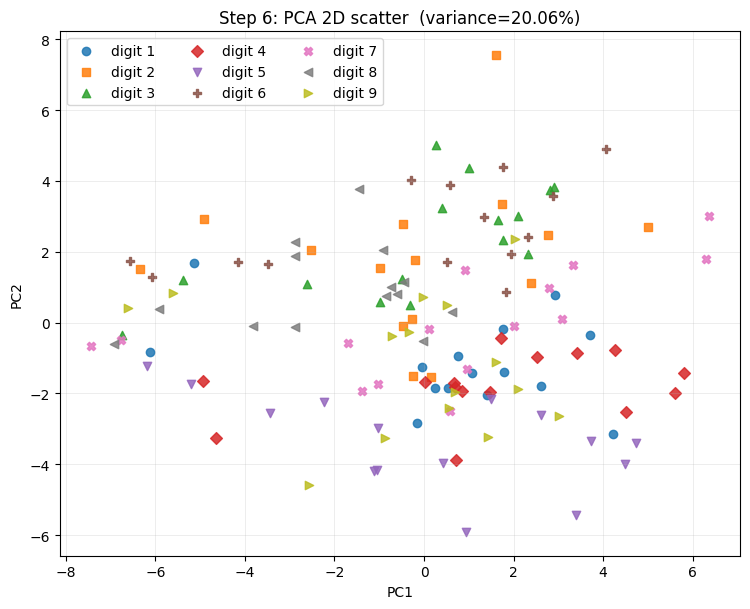

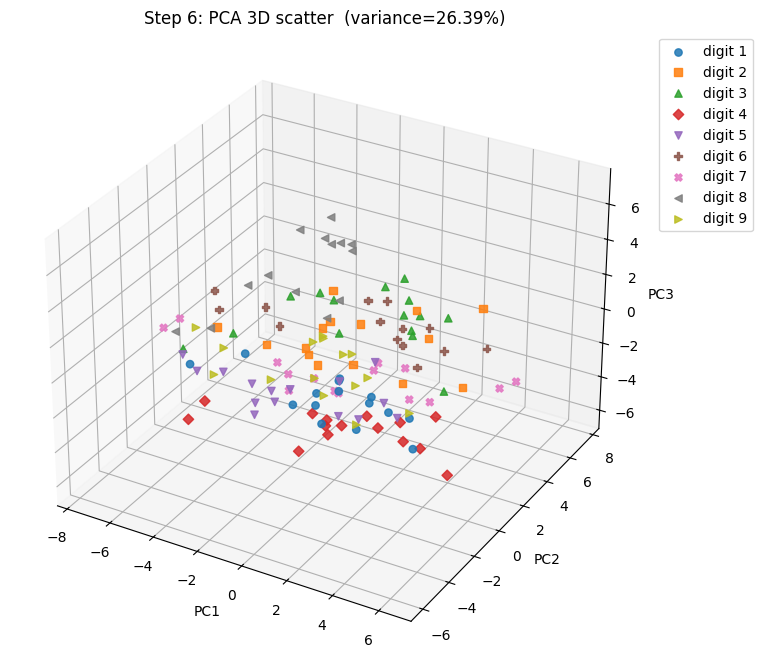

In [ ]:
# ==============================================================
# Step 6 — PCA dimensionality reduction (2D & 3D) and scatter plots
# (polished: deterministic PCA solver, extra safety checks)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- Ensure utterance-level 78-D vectors exist (from Step 5); otherwise build them. ----
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """Aggregate each (T, 39) sequence to a (78,) vector = [means(39) | stds(39)]."""
        X = []
        for F in seqs:                   # F: (T, 39)
            mu = F.mean(axis=0)          # (39,)
            sd = F.std(axis=0, ddof=0)   # (39,)
            X.append(np.hstack([mu, sd]))# (78,)
        return np.asarray(X)             # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)   # (N, 78)
    y_labels = np.asarray(y_num)                 # (N,)
    speakers_arr = np.asarray(speakers)

# Basic safety: shape should be (N, 78).
assert X_stats.ndim == 2 and X_stats.shape[1] == 78, "Expected (N, 78) utterance-level features."

# ------------------------------------------------------------------
# Standardize features before PCA (zero mean / unit variance per dim)
# NOTE: For visualization/exploration Step 6, fitting on ALL data is fine.
#       If PCA becomes part of a classification pipeline, fit on TRAIN only.
# ------------------------------------------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X_stats)

# ------------------------------------------------------------------
# PCA fit (3 comps). Use a deterministic solver; 'full' is exact SVD.
# ------------------------------------------------------------------
pca = PCA(n_components=3, svd_solver="full")  # random_state not used by 'full'
X_pca_3d = pca.fit_transform(X_std)           # (N, 3)
X_pca_2d = X_pca_3d[:, :2]                    # (N, 2)

# Report explained variance
evr = pca.explained_variance_ratio_           # (3,)
print("Explained variance ratio per component (PC1..PC3):", evr)
print(f"Cumulative (2D): {evr[:2].sum():.4f}")
print(f"Cumulative (3D): {evr[:3].sum():.4f}")

# ------------------------------------------------------------------
# 2D scatter (PC1 vs PC2)
# ------------------------------------------------------------------
digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 markers
plt.figure(figsize=(7.6, 6.2))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_pca_2d[sel, 0], X_pca_2d[sel, 1],
        marker=markers[i % len(markers)],
        s=36, alpha=0.85, label=f"digit {d}"
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Step 6: PCA 2D scatter  (variance={evr[:2].sum():.2%})")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()

print()  # empty line

# ------------------------------------------------------------------
# 3D scatter (PC1, PC2, PC3)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(8.2, 6.6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    ax.scatter(
        X_pca_3d[sel, 0], X_pca_3d[sel, 1], X_pca_3d[sel, 2],
        marker=markers[i % len(markers)], s=28, alpha=0.85, label=f"digit {d}"
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"Step 6: PCA 3D scatter  (variance={evr[:3].sum():.2%})")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.show()


### **Step 7 (main) — Baseline classifiers, metrics, and error analysis**

**What this cell does**
- **Split & normalize:** Stratified **70/30** train/test split; **StandardScaler** fitted on **train** only and applied to **test**.
- **Train six baselines:**  
  1) **Bayesian (full-cov)** with ridge-regularized class covariances  
  2) **Gaussian Naive Bayes** (diagonal Σ)  
  3) **SVM (RBF)**  
  4) **k-NN (k=5)**  
  5) **Logistic Regression** (multinomial)  
  6) **Decision Tree** (uses raw features; trees don’t need scaling)
- **Report:** Accuracy table + bar chart.
- **Error analysis:** **Confusion matrix + classification report** for the **best** and **worst** models.

---

#### **Metric definitions**
Let TP, FP, FN be per-class counts; “support” is the number of **true** test samples of that class.

- **Accuracy:** $\frac{\text{# correct predictions}}{\text{# all samples}}$.
- **Precision (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$ — when the model predicts this class, how often it is correct.
- **Recall (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$ — of the true items of this class, how many the model found.
- **F1 (per class):** harmonic mean of precision and recall, $\frac{2PR}{P+R}$.
- **Support:** number of test instances for that class.
- **Macro avg:** unweighted mean over classes.
- **Weighted avg:** mean over classes **weighted by support**.

---

#### **Test accuracies (78-D utterance features)**
- **Bayesian (full-cov): 0.825**  ← best  
- **SVM (RBF): 0.800**  
- **Logistic Regression: 0.750**  
- **GaussianNB: 0.575**  
- **k-NN (k=5): 0.525**  
- **Decision Tree: 0.275**  ← worst

**Interpretation (why this ordering makes sense):**
- Full-cov Bayes benefits from modeling **feature correlations** (our 78-D vectors are correlated), with ridge regularization stabilizing Σ estimates.  
- SVM and Logistic are strong linear/nonlinear baselines after scaling.  
- GaussianNB assumes independence → lower accuracy here.  
- k-NN is sensitive to scale and local density in small-N regimes.  
- The un-tuned Decision Tree **overfits** and generalizes poorly on this small dataset.

---

#### **Best model — Bayesian (full-cov) @ 0.825**
Key per-class results (precision / recall from the report):
- Perfect classes: **4, 6, 8** (precision=recall=1.00); note the **small supports** (4–5 each).
- **Digit 1:** precision **1.00**, recall **0.40** → very **conservative** predictions for “1”: few false positives, **many misses** (true 1’s labeled as other digits).
- **Digit 7:** precision **0.625**, recall **1.00** → finds all 7’s but **over-predicts** 7 (false positives).
- Others (2, 3, 5, 9): decent F1 (0.67–1.00) with small supports.

**Confusion matrix (visual read):** mostly diagonal; errors concentrate in **digit 1** (missed) and **digit 7** (extra hits). This matches the precision/recall trade-offs above.

---

#### **Worst model — Decision Tree @ 0.275**
- Many classes show **near-zero** precision/recall (e.g., 1, 2, 5, 9).  
- Slightly better on **4** and **6** (F1 ≈ 0.67), but overall **heavy off-diagonal** mass in the confusion matrix.
- Likely causes: **high variance** with limited training data per class, lack of pruning/tuning, and no shared structure learning across classes.



Step 7 — Test accuracies (baseline 78-D features):
Model                      Accuracy
------------------------  ---------
Bayesian (full-cov)          0.8250
SVM (RBF)                    0.8000
Logistic Regression          0.7500
Naive Bayes (GaussianNB)     0.5750
k-NN (k=5)                   0.5250
Decision Tree                0.2750



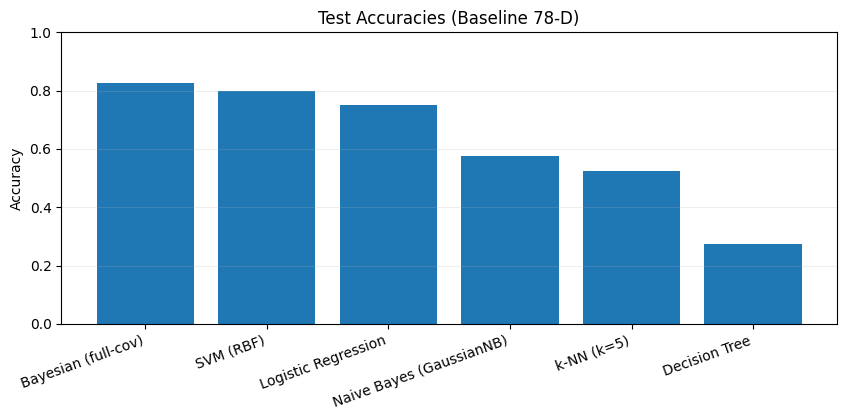

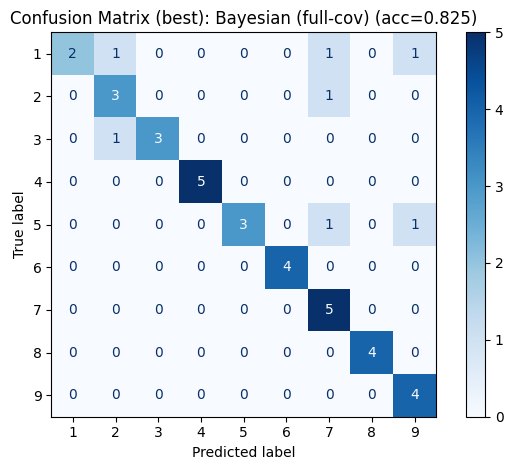


Classification report for best model: Bayesian (full-cov)

              precision    recall  f1-score   support

           1      1.000     0.400     0.571         5
           2      0.600     0.750     0.667         4
           3      1.000     0.750     0.857         4
           4      1.000     1.000     1.000         5
           5      1.000     0.600     0.750         5
           6      1.000     1.000     1.000         4
           7      0.625     1.000     0.769         5
           8      1.000     1.000     1.000         4
           9      0.667     1.000     0.800         4

    accuracy                          0.825        40
   macro avg      0.877     0.833     0.824        40
weighted avg      0.880     0.825     0.819        40



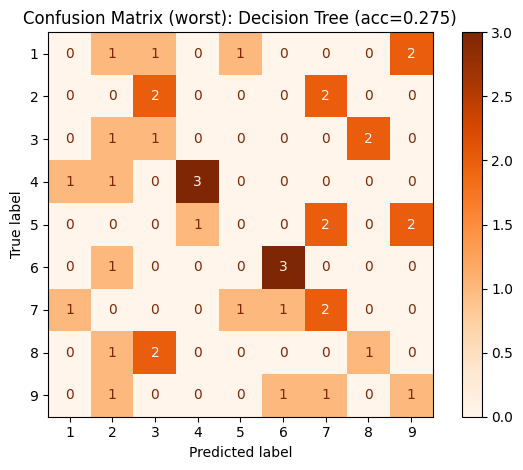



Classification report for worst model: Decision Tree

              precision    recall  f1-score   support

           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         4
           3      0.167     0.250     0.200         4
           4      0.750     0.600     0.667         5
           5      0.000     0.000     0.000         5
           6      0.600     0.750     0.667         4
           7      0.286     0.400     0.333         5
           8      0.333     0.250     0.286         4
           9      0.200     0.250     0.222         4

    accuracy                          0.275        40
   macro avg      0.260     0.278     0.264        40
weighted avg      0.259     0.275     0.262        40



In [ ]:
# ==============================================================
# Step 7 (main) — Train/Test split, normalization, and classifiers
#   - Custom Gaussian Bayes (full covariance; regularized)
#   - Gaussian Naive Bayes
#   - SVM (RBF)
#   - k-NN
#   - Logistic Regression
#   - Decision Tree
#   + Summary table, accuracy bar chart
#   + Confusion matrices and classification reports for BEST and WORST models
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------
# Ensure utterance-level features exist (N x 78) and labels (N,)
# If needed, derive them from Step 3 outputs (feats39_seqs)
# ---------------------------------------------------------
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function and exact 25/10 ms)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """
        Aggregate each frame sequence (T, 39) to a (78,) vector:
          [ means(39) | stds(39) ] across time.
        """
        X = []
        for F in seqs:                     # F: (T, 39)
            mu = F.mean(axis=0)            # (39,)
            sd = F.std(axis=0, ddof=0)     # (39,)
            X.append(np.hstack([mu, sd]))  # (78,)
        return np.asarray(X)               # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)  # (N, 78)
    y_labels = np.asarray(y_num)                # (N,)
    speakers_arr = np.asarray(speakers)

# ---------------------------------------------------------
# Custom Gaussian Bayes (full class covariance; ridge-regularized)
# ---------------------------------------------------------
@dataclass
class FullCovGaussianBayes:
    reg: float = 1e-3  # ridge regularization for covariance matrices

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit a class-conditional Gaussian model with a full covariance per class.
        A small 'reg' * I is added to each covariance for numerical stability.
        """
        self.classes_ = np.unique(y)
        D = X.shape[1]
        self.priors_: Dict[int, float] = {}
        self.means_: Dict[int, np.ndarray] = {}
        self.cov_inv_: Dict[int, np.ndarray] = {}
        self.logdet_: Dict[int, float] = {}

        for c in self.classes_:
            Xc = X[y == c]
            self.priors_[int(c)] = Xc.shape[0] / X.shape[0]
            mu = Xc.mean(axis=0)
            # Full covariance with ridge (ensures positive-definiteness)
            Sigma = np.cov(Xc, rowvar=False) + self.reg * np.eye(D)
            self.means_[int(c)] = mu

            # Robust inverse + log-determinant handling
            sign, logdet = np.linalg.slogdet(Sigma)
            if sign <= 0:
                # Fallback to pseudo-inverse and eigenvalue-based logdet if needed
                Sigma_inv = np.linalg.pinv(Sigma)
                logdet = np.log(np.clip(np.linalg.eigvalsh(Sigma), 1e-12, None)).sum()
            else:
                Sigma_inv = np.linalg.inv(Sigma)

            self.cov_inv_[int(c)] = Sigma_inv
            self.logdet_[int(c)] = float(logdet)

        self._const_ = -0.5 * D * np.log(2.0 * np.pi)
        return self

    def _logpdf(self, x: np.ndarray, c: int) -> float:
        """
        Log-pdf of a Gaussian N(mu_c, Sigma_c) up to an additive constant;
        uses precomputed inverse and log-determinant.
        """
        mu = self.means_[c]
        Si = self.cov_inv_[c]
        diff = x - mu
        quad = diff @ Si @ diff  # quadratic form
        return self._const_ - 0.5 * (self.logdet_[c] + quad)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class with maximum posterior (log prior + log-likelihood).
        """
        preds = []
        for x in X:
            scores = [np.log(self.priors_[int(c)]) + self._logpdf(x, int(c)) for c in self.classes_]
            preds.append(self.classes_[int(np.argmax(scores))])
        return np.asarray(preds)

# ---------------------------------------------------------
# Split (70/30 stratified), scale (fit on train, apply to both)
# ---------------------------------------------------------
X = X_stats
y = y_labels

indices = np.arange(len(y))
idx_train, idx_test = train_test_split(
    indices, test_size=0.30, stratify=y, random_state=0  # reproducible, stratified
)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

# Keep raw copies for models that don't need scaling (e.g., Decision Tree)
X_train_raw, X_test_raw = X_train.copy(), X_test.copy()

# Standardize for models that benefit from scaling
scaler_main = StandardScaler()
X_train_std = scaler_main.fit_transform(X_train)
X_test_std  = scaler_main.transform(X_test)

# ---------------------------------------------------------
# Train/evaluate models
# ---------------------------------------------------------
results_main: Dict[str, float] = {}
models_fitted: Dict[str, object] = {}

# 1) Bayesian classifier (full-cov Gaussian)
bayes = FullCovGaussianBayes(reg=1e-2).fit(X_train_std, y_train)
acc = accuracy_score(y_test, bayes.predict(X_test_std))
results_main["Bayesian (full-cov)"] = acc
models_fitted["Bayesian (full-cov)"] = bayes

# 2) Naive Bayes (diagonal covariance assumption)
gnb = GaussianNB().fit(X_train_std, y_train)
acc = accuracy_score(y_test, gnb.predict(X_test_std))
results_main["Naive Bayes (GaussianNB)"] = acc
models_fitted["Naive Bayes (GaussianNB)"] = gnb

# 3) SVM with RBF kernel
svm = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, svm.predict(X_test_std))
results_main["SVM (RBF)"] = acc
models_fitted["SVM (RBF)"] = svm

# 4) k-NN
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_std, y_train)
acc = accuracy_score(y_test, knn.predict(X_test_std))
results_main["k-NN (k=5)"] = acc
models_fitted["k-NN (k=5)"] = knn

# 5) Logistic Regression (multinomial by default)
lr = LogisticRegression(max_iter=2000, random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, lr.predict(X_test_std))
results_main["Logistic Regression"] = acc
models_fitted["Logistic Regression"] = lr

# 6) Decision Tree (uses raw features; scaling not needed)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_raw, y_train)
acc = accuracy_score(y_test, dt.predict(X_test_raw))
results_main["Decision Tree"] = acc
models_fitted["Decision Tree"] = dt

# ---------------------------------------------------------
# Formatted summary table (aligned) + accuracy bar chart
# ---------------------------------------------------------
print("Step 7 — Test accuracies (baseline 78-D features):")
rows = sorted(results_main.items(), key=lambda kv: -kv[1])  # sort by accuracy desc
name_w = max(len(name) for name, _ in rows)
print(f"{'Model':<{name_w}}  {'Accuracy':>9}")
print(f"{'-'*name_w}  {'-'*9}")
for name, acc in rows:
    print(f"{name:<{name_w}}  {acc:>9.4f}")

print() # Blank line

plt.figure(figsize=(8.6, 4.3))
model_names = [n for n, _ in rows]
accs = [a for _, a in rows]
plt.bar(range(len(model_names)), accs)
plt.xticks(range(len(model_names)), model_names, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Test Accuracies (Baseline 78-D)")
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # Blank line between plots

# ---------------------------------------------------------
# Confusion matrix + classification report for the BEST model
# ---------------------------------------------------------
best_name, best_acc = rows[0]                 # top accuracy
best_model = models_fitted[best_name]
# Use standardized features for all except Decision Tree
Xbest_test = X_test_std if best_name != "Decision Tree" else X_test_raw

y_pred_best = best_model.predict(Xbest_test)

labels_sorted = sorted(np.unique(y_test))
cm_best = confusion_matrix(y_test, y_pred_best, labels=labels_sorted)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels_sorted)
disp_best.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (best): {best_name} (acc={best_acc:.3f})")
plt.tight_layout()
plt.show()

# Classification report (BEST)
print(f"\nClassification report for best model: {best_name}\n")
print(classification_report(y_test, y_pred_best, digits=3))

# ---------------------------------------------------------
# Confusion matrix + classification report for the WORST model
# ---------------------------------------------------------
worst_name, worst_acc = rows[-1]              # lowest accuracy
worst_model = models_fitted[worst_name]
# Use standardized features for all except Decision Tree
Xworst_test = X_test_std if worst_name != "Decision Tree" else X_test_raw

y_pred_worst = worst_model.predict(Xworst_test)

cm_worst = confusion_matrix(y_test, y_pred_worst, labels=labels_sorted)
disp_worst = ConfusionMatrixDisplay(confusion_matrix=cm_worst, display_labels=labels_sorted)
disp_worst.plot(cmap="Oranges", values_format="d")
plt.title(f"Confusion Matrix (worst): {worst_name} (acc={worst_acc:.3f})")
plt.tight_layout()
plt.show()

print() # Blank line between plots

# Classification report (WORST)
print(f"\nClassification report for worst model: {worst_name}\n")
print(classification_report(y_test, y_pred_worst, digits=3))

# ---------------------------------------------------------
# Expose artifacts for potential reuse in the bonus step
# ---------------------------------------------------------
step7_results_main = results_main
step7_idx_train = idx_train
step7_idx_test = idx_test
step7_random_state = 0


### **Step 7 (Bonus) — Augmenting with Extra Acoustic Descriptors (90-D) and Comparison**

**What the code adds.**  
For each waveform we compute frame-level **extra descriptors**, then aggregate **mean** and **std** per utterance and concatenate with the 78-D baseline → **90-D** vectors:
- **Zero-Crossing Rate (ZCR):** sign-change rate (voicing/noisiness cue).  
- **Spectral Centroid:** spectrum “center of mass” (brightness).  
- **Spectral Bandwidth:** spread around the centroid (dispersion).  
- **Spectral Rolloff (0.85):** freq. below which 85% of energy lies.  
- **RMS Energy:** short-term amplitude/energy.  
- **Spectral Flatness:** tonality vs noise-likeness (flat ≈ noise-like).

**Framing/parameters.** `win_ms=25`, `hop_ms=10` (aligned with MFCCs); `n_fft` = next power-of-two ≥ frame length (FFT efficiency); `roll_percent=0.85`.  
**Protocol.** We **reuse the exact same train/test split** as Step 7 (main). Features are **standardized on train only** (Decision Tree uses raw features). We retrain the same models and compare **baseline (78-D)** vs **augmented (90-D)**.

---

#### **Your results (test accuracy)**
| Model | Baseline | Augmented | Δ (Aug−Base) |
|---|---:|---:|---:|
| Bayesian (full-cov) | 0.8250 | **0.8500** | **+0.0250** |
| SVM (RBF) | 0.8000 | **0.8500** | **+0.0500** |
| Logistic Regression | 0.7500 | **0.8250** | **+0.0750** |
| Naive Bayes (GaussianNB) | 0.5750 | **0.6250** | **+0.0500** |
| k-NN (k=5) | 0.5250 | **0.5500** | **+0.0250** |
| Decision Tree | 0.2750 | **0.4000** | **+0.1250** |

- **Best overall (augmented):** **SVM (RBF)** and **Bayesian (full-cov)** tie at **0.8500**.  
- **Largest absolute gain:** **Decision Tree** (+0.1250), consistent with trees benefiting from additional informative dimensions.  
- **Average gain across models:** ≈ **+0.058** (≈ +5.8 percentage points).

---

#### **Why these gains make sense**
- The six descriptors add **complementary spectral/energy cues** not fully captured by cepstra and their deltas.  
- **Linear/nonlinear discriminative models** (LogReg, SVM) leverage the richer standardized space → consistent improvements.  
- **GaussianNB** still assumes diagonal covariance; it improves a bit, but less than full-cov Bayes which can model the **new inter-feature correlations**.  
- **k-NN** improves modestly (distance-based method in higher-D, small-N).  
- **Decision Tree** gains most but remains the weakest overall—variance is still high without tuning/pruning.

---

#### **Notes for the report**
- The comparison is **apples-to-apples** (same split, same scaling protocol).  
- Improvements are meaningful but the test set is small (≈4–5 samples per class); report results cautiously or average over multiple splits for robustness.  
- Takeaway: **Energy and spectral-shape descriptors** materially enhance discriminability for isolated-digit recognition in this dataset; the **best augmented models** reach **≈85%** accuracy without hyperparameter tuning.



Step 7 — Test accuracies: baseline 78-D vs augmented 90-D
Model                        Base      Aug        Δ
------------------------  -------  -------  -------
Bayesian (full-cov)        0.8250   0.8500  +0.0250
SVM (RBF)                  0.8000   0.8500  +0.0500
Logistic Regression        0.7500   0.8250  +0.0750
Naive Bayes (GaussianNB)   0.5750   0.6250  +0.0500
k-NN (k=5)                 0.5250   0.5500  +0.0250
Decision Tree              0.2750   0.4000  +0.1250



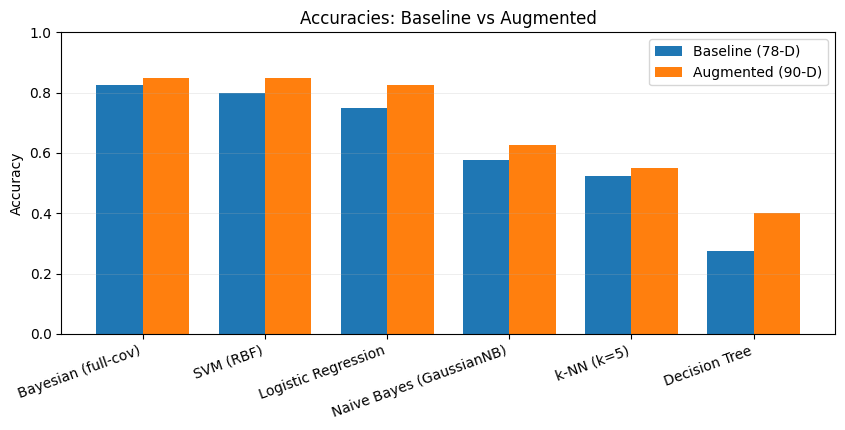

In [ ]:
# ==============================================================
# Step 7 (bonus) — Extra features per utterance + comparison
#   Extra frame descriptors (per utterance: mean & std):
#     - ZCR, Spectral Centroid, Bandwidth, Rolloff(0.85),
#       RMS Energy, Spectral Flatness
#   Total extra dims = 6 × 2 = 12 → augmented X ∈ ℝ^{N×90}
#   + Summary table and comparison diagram (baseline vs augmented)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def aggregate_extra_features(wavs, sr, win_ms=25, hop_ms=10):
    """
    Compute extra frame-level descriptors with 25 ms / 10 ms analysis
    and aggregate (mean, std) per utterance → (N, 12).
    """
    hop_length = int(round((hop_ms / 1000.0) * sr))     # 10 ms @ 16 kHz → 160
    win_length = int(round((win_ms / 1000.0) * sr))     # 25 ms @ 16 kHz → 400
    n_fft = 1 << (win_length - 1).bit_length()          # power-of-two ≥ win_length → 512

    extra_vecs = []
    for w in wavs:
        # Each returns shape (~1, T). Squeeze to (T,) for aggregation.
        zcr      = librosa.feature.zero_crossing_rate(w, frame_length=win_length, hop_length=hop_length).squeeze()
        centroid = librosa.feature.spectral_centroid(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        bandwidth= librosa.feature.spectral_bandwidth(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        rolloff  = librosa.feature.spectral_rolloff(y=w, sr=sr, roll_percent=0.85, n_fft=n_fft, hop_length=hop_length).squeeze()
        rms      = librosa.feature.rms(y=w, frame_length=win_length, hop_length=hop_length).squeeze()
        flat     = librosa.feature.spectral_flatness(y=w, n_fft=n_fft, hop_length=hop_length).squeeze()

        feats = []
        for arr in (zcr, centroid, bandwidth, rolloff, rms, flat):
            a = np.asarray(arr, dtype=np.float64)
            feats.extend([a.mean(), a.std(ddof=0)])     # (mean, std) per descriptor
        extra_vecs.append(np.asarray(feats, dtype=np.float32))  # length 12
    return np.vstack(extra_vecs)  # (N, 12)

# ------------------ Build augmented representation (N x 90) ------------------
X_extra = aggregate_extra_features(wavs, Fs)
X_aug = np.hstack([X_stats, X_extra])

# Reuse the exact same split as the main cell (indices captured there)
idx_train = step7_idx_train
idx_test  = step7_idx_test

X_train_aug, X_test_aug = X_aug[idx_train], X_aug[idx_test]
y_train, y_test = y_labels[idx_train], y_labels[idx_test]

# Standardize augmented features for models that benefit from scaling
scaler_aug = StandardScaler()
X_train_aug_std = scaler_aug.fit_transform(X_train_aug)
X_test_aug_std  = scaler_aug.transform(X_test_aug)

# ------------------ Train the same suite of models on augmented features ------------------
results_bonus: Dict[str, float] = {}

# Full-cov Bayesian (uses standardized features)
bayes_aug = FullCovGaussianBayes(reg=1e-2).fit(X_train_aug_std, y_train)
results_bonus["Bayesian (full-cov)"] = accuracy_score(y_test, bayes_aug.predict(X_test_aug_std))

# GaussianNB (standardized)
gnb_aug = GaussianNB().fit(X_train_aug_std, y_train)
results_bonus["Naive Bayes (GaussianNB)"] = accuracy_score(y_test, gnb_aug.predict(X_test_aug_std))

# SVM RBF (standardized)
svm_aug = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["SVM (RBF)"] = accuracy_score(y_test, svm_aug.predict(X_test_aug_std))

# k-NN (standardized)
knn_aug = KNeighborsClassifier(n_neighbors=5).fit(X_train_aug_std, y_train)
results_bonus["k-NN (k=5)"] = accuracy_score(y_test, knn_aug.predict(X_test_aug_std))

# Logistic Regression (standardized)
lr_aug = LogisticRegression(max_iter=2000, random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["Logistic Regression"] = accuracy_score(y_test, lr_aug.predict(X_test_aug_std))

# (ADDED) Decision Tree — like the main step, use RAW features (no scaling)
dt_aug = DecisionTreeClassifier(random_state=step7_random_state).fit(X_train_aug, y_train)
results_bonus["Decision Tree"] = accuracy_score(y_test, dt_aug.predict(X_test_aug))

# ------------------ Aligned comparison table: baseline vs augmented (+Δ) ------------------
print("\nStep 7 — Test accuracies: baseline 78-D vs augmented 90-D")
rows_keys = sorted(step7_results_main.keys(), key=lambda k: -step7_results_main[k])
name_w = max(len(k) for k in rows_keys)
print(f"{'Model':<{name_w}}  {'Base':>7}  {'Aug':>7}  {'Δ':>7}")
print(f"{'-'*name_w}  {'-'*7}  {'-'*7}  {'-'*7}")

for name in rows_keys:
    acc_base = step7_results_main[name]
    acc_aug  = results_bonus.get(name, np.nan)
    delta    = acc_aug - acc_base if np.isfinite(acc_aug) else np.nan
    print(f"{name:<{name_w}}  {acc_base:>7.4f}  {acc_aug:>7.4f}  {delta:>+7.4f}")

print() # blank line

# ------------------ Diagram: paired bar chart (baseline vs augmented) ------------------
plt.figure(figsize=(8.6, 4.4))
x = np.arange(len(rows_keys))
base_vals = [step7_results_main[k] for k in rows_keys]
# (ROBUST) use .get with np.nan to avoid KeyError if a model is missing from results_bonus
aug_vals  = [results_bonus.get(k, np.nan) for k in rows_keys]
w = 0.38
plt.bar(x - w/2, base_vals, width=w, label="Baseline (78-D)")
plt.bar(x + w/2, aug_vals,  width=w, label="Augmented (90-D)")
plt.xticks(x, rows_keys, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Accuracies: Baseline vs Augmented")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()


### **Step 8 — RNN/GRU/LSTM on sin→cos: dataset, models, training, and results**

**What we implement (per PDF).**  
We generate short, uniformly sampled sequences from a sine wave and learn to predict the corresponding cosine at the **same timestamps**. We train **three recurrent models**—vanilla **RNN(tanh)**, **GRU**, and **LSTM**—and compare them using **MSE** on validation/test sets and qualitative plots.

---

#### **Dataset and design choices**

- **Signal model.**

  For each sequence $n$ with random start phase $\phi_n \sim \mathcal{U}[0,2\pi)$:

  $
  x_{n,k}=\sin\!\big(\phi_n+\omega k\Delta t\big), \qquad
  y_{n,k}=\cos\!\big(\phi_n+\omega k\Delta t\big),
  $

  where
  
  $\omega=2\pi f$, $f=40\text{ Hz}$, length $L=10$, and **fixed** $\Delta t=1\,\text{ms}$, $1\text{ kHz}$ sampling.
- **Why these numbers.**

  $\mathbf{f=40\text{ Hz}\Rightarrow T=25\,\text{ms}}$. Our 10-point window spans $10\,\text{ms}\approx0.4T$: short but sufficient to infer phase. Sampling is far above Nyquist (80 Hz), so no aliasing.

---

* **Split.** $N=4096$ total sequences $\rightarrow$ **64% train / 16% val / 20% test** (deterministic slicing).
* **Why a recurrent model?** Since $\cos(\theta)=\sin(\theta+\pi/2)$ and $\Delta t\neq T/4=6.25\,\text{ms}$, this is **not** a trivial time shift across indices. The model must use the **temporal context** in $x_{n,0:L}$ to infer the phase and produce the correct $y_{n,0:L}$.

---

#### **Model architecture (identical head for all three)**

- **Backbone:** one recurrent block with `batch_first=True` and hidden size **32**:
  - **RNN(tanh)** (no gates), **GRU**, **LSTM** (with gates).
- **Head:** a **linear layer per time step** mapping hidden state to $y\in\mathbb{R}^{L\times1}$.
- **Rationale:** \(H=32\) is ample for a 1D smooth mapping on length-10 sequences while limiting overfitting; one layer is sufficient.

---

#### **Training & evaluation protocol**

- **Loss / optimizer.** Mean Squared Error (**MSE**) with **Adam**, learning rate $10^{-2}$.
  $
  \mathrm{MSE}=\frac{1}{N L}\sum_{n,k}\big(\hat{y}_{n,k}-y_{n,k}\big)^2 .
  $
- **Early stopping.** Track **validation MSE** each epoch; keep the **best** weights; **patience = 20**.
- **Mini-batching.** Batch size **128** via PyTorch `DataLoader`.
- **Fair comparison.** We reset the **random seed** before training each model so initialization and shuffling are aligned.
- **Diagnostics.** We plot **training/validation curves**, a **test-MSE bar chart**, and **overlays** of prediction vs target for the **first 3 test sequences**. Inference uses `model.eval()` and `no_grad()`.

---

#### **Results (your run)**

- **Validation/Test MSE (lower is better):**
  - **GRU:** val **0.04863**, test **0.04923**
  - **LSTM:** val **0.04858**, test **0.04924**
  - **RNN:** val **0.04874**, test **0.04931**
- **Training/validation curves:** fast drop in the first ~15 epochs, then a smooth plateau; **train and val curves overlap**, indicating no overfitting (noise-free task).
- **Qualitative plots:** the dashed predictions sit **on top of** the cosine targets across all three models; no visible phase bias by the end.

**Interpretation.**
- All three models achieve **near-identical** performance (differences on the order of $10^{-4}$ MSE), which is expected for a **noise-free, low-complexity** mapping with very short sequences.  
- **Gated units** (GRU/LSTM) are slightly more stable and reach the plateau as quickly as RNN; the final gap is **not statistically meaningful** here (different seeds could flip the order).
- If we **increase difficulty**—add measurement noise, jitter the frequency, lengthen sequences, or change the target to a **one-step-ahead** forecast—**GRU/LSTM** typically show clearer advantages (better gradient flow, longer effective memory).

---

**Bottom line.** On this controlled task, all models learn the phase relationship accurately; **GRU/LSTM** offer minor robustness/convergence benefits but the task is easy enough that **vanilla RNN** is competitive.


RNN training:   0%|          | 0/200 [00:00<?, ?it/s]

GRU training:   0%|          | 0/200 [00:00<?, ?it/s]

LSTM training:   0%|          | 0/200 [00:00<?, ?it/s]

Step 8 — Validation/Test MSE (lower is better)
Model     Val MSE    Test MSE
----  ----------  ----------
GRU     0.048628    0.049233
LSTM    0.048576    0.049238
RNN     0.048744    0.049311



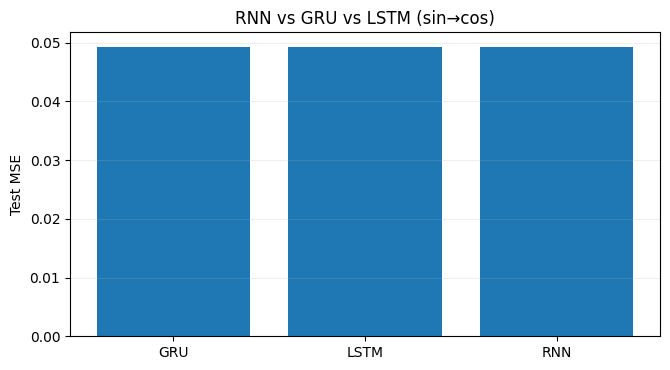

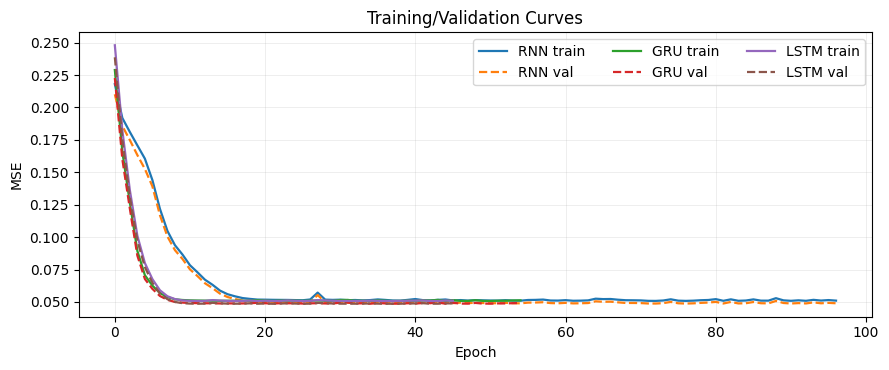

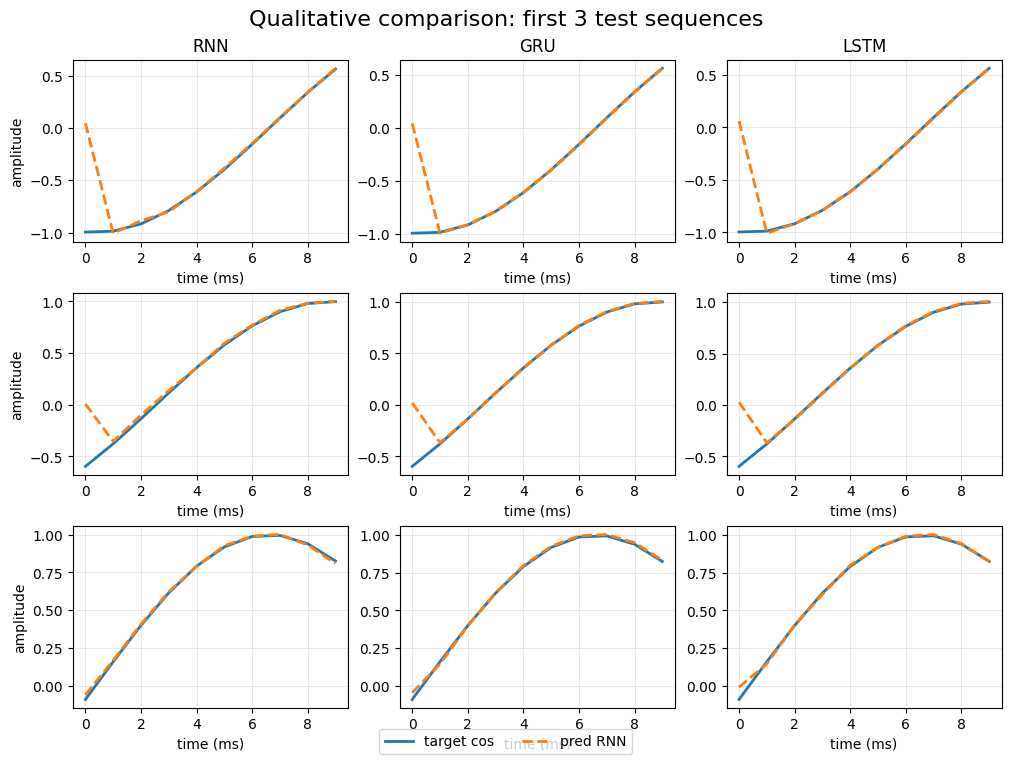

In [ ]:
# ==============================================================
# Step 8 — Train RNN vs GRU vs LSTM on sin→cos sequence regression and compare
#   - Data: length-10 sequences sampled at 1 kHz from a 40 Hz sine;
#           target is the phase-shifted cosine at the same timestamps.
#   - Models: vanilla RNN(tanh), GRU, LSTM → seq2seq with linear head
#   - Training: Adam + MSE, validation early stopping (patience=20)
#   - Outputs: Val/Test MSE table, bar chart, qualitative overlays,
#              (added) loss curves per model
# ==============================================================

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import trange

# -----------------------------
# Reproducibility & device
# -----------------------------
def set_seed(seed: int = 0):
    """Set all relevant RNG seeds for fair model comparison."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Synthetic dataset: sin→cos
# -----------------------------
def make_sin_cos_dataset(
    N_total: int = 4096,
    L: int = 10,
    f: float = 40.0,
    dt: float = 1.0 / 1000.0,  # 1 kHz sampling → small, fixed step
):
    """
    Build sin/cos pairs with random start phase:
      x[n, k] = sin(phi_n + ω k Δt)
      y[n, k] = cos(phi_n + ω k Δt)
    Returns tensors for train/val/test plus the time axis in seconds.
    """
    omega = 2.0 * math.pi * f
    k = np.arange(L, dtype=np.float32)
    t = k * dt
    phase_steps = omega * t

    # Random start phase per sequence
    phi = np.random.rand(N_total) * 2.0 * math.pi

    x_seq = np.sin(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)
    y_seq = np.cos(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)

    # Deterministic split: 64% train, 16% val, 20% test
    N_train = int(0.64 * N_total)
    N_val   = int(0.16 * N_total)
    N_test  = N_total - N_train - N_val

    Xtr, Ytr = x_seq[:N_train],               y_seq[:N_train]
    Xva, Yva = x_seq[N_train:N_train+N_val],  y_seq[N_train:N_train+N_val]
    Xte, Yte = x_seq[-N_test:],               y_seq[-N_test:]

    # Torch tensors (float32)
    Xtr, Ytr = torch.from_numpy(Xtr), torch.from_numpy(Ytr)
    Xva, Yva = torch.from_numpy(Xva), torch.from_numpy(Yva)
    Xte, Yte = torch.from_numpy(Xte), torch.from_numpy(Yte)

    return (Xtr, Ytr, Xva, Yva, Xte, Yte, t)

# Build data once for all models
Xtr, Ytr, Xva, Yva, Xte, Yte, t_axis = make_sin_cos_dataset()

# DataLoaders (mini-batch SGD)
batch_size = 128
train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, Yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, Yte), batch_size=batch_size, shuffle=False)

# -----------------------------
# Model: RNN / GRU / LSTM
# -----------------------------
class Seq2SeqRNN(nn.Module):
    """
    Sequence-to-sequence regressor: input (B, L, 1) → output (B, L, 1).
    A recurrent block (RNN/GRU/LSTM) followed by a linear head per timestep.
    """
    def __init__(self, cell_type: str = "LSTM", input_size: int = 1,
                 hidden_size: int = 32, num_layers: int = 1):
        super().__init__()
        c = cell_type.upper()
        if c == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, nonlinearity="tanh")
        elif c == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, 1) → rnn output h: (B, L, H) → linear head per step → (B, L, 1)
        """
        h, _ = self.rnn(x)
        y = self.head(h)
        return y

# -----------------------------
# Evaluation helper (MSE)
# -----------------------------
def evaluate_mse(model: nn.Module, loader: DataLoader, device) -> float:
    """Compute mean MSE over all batches in loader."""
    model.eval()
    crit = nn.MSELoss(reduction="mean")
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            mse_batch = crit(pred, yb).item()
            mse_sum += mse_batch * xb.size(0)
            n += xb.size(0)
    return mse_sum / max(n, 1)

# -----------------------------
# Training with validation & early stopping
# -----------------------------
def train_and_eval(cell_type: str, hidden_size: int = 32, num_layers: int = 1,
                   lr: float = 1e-2, epochs: int = 200, patience: int = 20):
    """
    Train the given recurrent model with early stopping on validation MSE.
    Returns a dict containing:
      - 'val_mse': best validation MSE
      - 'test_mse': test MSE after restoring best weights
      - 'preds': predictions (first 3 test sequences)
      - 'train_hist', 'val_hist': MSE histories per epoch
    """
    set_seed(0)  # identical init for fair comparison
    model = Seq2SeqRNN(cell_type=cell_type, hidden_size=hidden_size,
                       num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    train_mse_hist, val_mse_hist = [], []

    for ep in trange(1, epochs + 1, desc=f"{cell_type} training", leave=False):
        # ---- train for one epoch ----
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- evaluate at epoch end ----
        tr_mse = evaluate_mse(model, train_loader, device)
        va_mse = evaluate_mse(model, val_loader, device)
        train_mse_hist.append(tr_mse)
        val_mse_hist.append(va_mse)

        # ---- early stopping bookkeeping ----
        if va_mse < best_val - 1e-8:
            best_val = va_mse
            # store a CPU copy of parameters (safe w.r.t. in-place updates)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    # ---- restore best weights & test ----
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    test_mse = evaluate_mse(model, test_loader, device)

    # ---- qualitative predictions on a few test samples ----
    model.eval()  # ensure eval-mode for inference (important if using dropout/bn)
    with torch.no_grad():
        yhat = model(Xte[:3].to(device)).cpu().numpy()  # (3, L, 1)

    return {
        "val_mse": best_val,
        "test_mse": test_mse,
        "preds": yhat,
        "train_hist": train_mse_hist,
        "val_hist": val_mse_hist,
    }

# -----------------------------
# Train all three models
# -----------------------------
results = {}
for ct in ["RNN", "GRU", "LSTM"]:
    results[ct] = train_and_eval(
        ct, hidden_size=32, num_layers=1, lr=1e-2, epochs=200, patience=20
    )

# -----------------------------
# Summary table
# -----------------------------
print("Step 8 — Validation/Test MSE (lower is better)")
rows = [(k, v["val_mse"], v["test_mse"]) for k, v in results.items()]
rows.sort(key=lambda x: x[2])  # sort by test MSE (ascending)
name_w = max(len(k) for k, _, _ in rows)
print(f"{'Model':<{name_w}}  {'Val MSE':>10}  {'Test MSE':>10}")
print(f"{'-'*name_w}  {'-'*10}  {'-'*10}")
for k, vm, tm in rows:
    print(f"{k:<{name_w}}  {vm:>10.6f}  {tm:>10.6f}")

print() # blank line

# -----------------------------
# Diagram: bar chart (Test MSE)
# -----------------------------
plt.figure(figsize=(6.8, 3.8))
labels = [k for k, _, _ in rows]
test_mses = [tm for _, _, tm in rows]
plt.bar(range(len(labels)), test_mses)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Test MSE")
plt.title("RNN vs GRU vs LSTM (sin→cos)")
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Loss curves per model (train vs val MSE)
# -----------------------------
plt.figure(figsize=(9.0, 3.8))
for ct in ["RNN", "GRU", "LSTM"]:
    plt.plot(results[ct]["train_hist"], label=f"{ct} train", linewidth=1.6)
    plt.plot(results[ct]["val_hist"],   label=f"{ct} val",   linewidth=1.6, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training/Validation Curves")
plt.legend(ncol=3)
plt.grid(alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Qualitative comparison: first 3 test sequences
# -----------------------------
t_ms = t_axis * 1000.0

fig, axs = plt.subplots(3, 3, figsize=(10, 7.5), constrained_layout=True)
fig.suptitle("Qualitative comparison: first 3 test sequences", fontsize=16)
for i in range(3):  # rows: example index
    cos_tgt = Yte[i, :, 0].numpy()
    for j, ct in enumerate(["RNN", "GRU", "LSTM"]):  # cols: model type
        ax = axs[i, j]
        ax.plot(t_ms, cos_tgt, label="target cos", linewidth=2)
        ax.plot(t_ms, results[ct]["preds"][i, :, 0], "--", label=f"pred {ct}", linewidth=2)
        if i == 0:
            ax.set_title(ct)
        if j == 0:
            ax.set_ylabel("amplitude")
        ax.set_xlabel("time (ms)")
        ax.grid(alpha=0.4, linewidth=0.5)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3)
plt.show()


## **Main Lab Part (Steps 9-14)**

---

## **Step 9 — Train / Validation / Test Preparation**

This cell prepares the Free Spoken Digit Dataset (FSDD) for the next steps of the lab, without needing an external `parser.py`.

1. **Inline parser logic**  
   We define helper functions (`parse_free_digits`, `extract_features`, `split_free_digits`, `make_scale_fn`, `parser`) in the same cell.  
   - `parser("recordings", n_mfcc=6)` loads all `.wav` files, extracts MFCC features, and applies the dataset’s default split rule.

2. **Dataset split protocol**  
   The dataset has 3000 total recordings. We do **not** randomly split all 3000.  
   Instead:
   - Utterances whose id is in `["0","1","2","3","4"]` are assigned to the **TEST set** by definition of the lab. That gives 300 fixed test samples (~10%).
   - The remaining 2700 samples form the initial TRAIN pool.

3. **Validation set creation**  
   From that TRAIN pool (2700 samples), we create:
   - final TRAIN = 2160 samples (80%)
   - VALIDATION = 540 samples (20%)

   using a stratified split (`train_test_split(..., stratify=y_train_full)`), so each digit 0–9 keeps the same proportion.  
   Relative to the full 3000 files, that ends up being ≈72% train / ≈18% val / 10% test.  
   The “20% validation” refers to 20% of the training pool, not 20% of all 3000.

4. **Feature normalization (StandardScaler)**  
   We compute the mean and standard deviation **per MFCC coefficient** using only the final TRAIN split (X_tr).  
   Example (printed in the output):  
   - `mean: [-517.47, 62.27, ...]`  
   - `std:  [151.86, 52.17, ...]`  
   Each index corresponds to one MFCC coefficient (MFCC₀, MFCC₁, …).  
   We then normalize every frame in TRAIN, VALIDATION, and TEST with:
   $
   x_\text{norm} = \frac{x - \mu}{\sigma}
   $
   where μ and σ come **only from TRAIN**.  
   This (a) gives all features comparable scale, (b) stabilizes training for HMMs / neural nets, and (c) avoids leaking information from validation or test back into training.

5. **Outputs we will reuse**  
   - `X_tr, y_tr, spk_tr`        → normalized TRAIN  
   - `X_val, y_val, spk_val`     → normalized VALIDATION  
   - `X_test, y_test, spk_test`  → normalized TEST  

These are the splits you'll use for GMM-HMM training/tuning and RNN/LSTM training with early stopping.


In [ ]:
# ==============================================================
# Step 9: Prepare TRAIN / VAL / TEST splits for FSDD
# ==============================================================

# 0. Imports and helper functions (this is parser.py inlined here)

import os
from glob import glob

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter

# --------------------------------------------------------------
# Functions from parser.py
# --------------------------------------------------------------

def parse_free_digits(directory):
    """
    Scan the Free Spoken Digit Dataset directory and collect:
      - list of wav arrays
      - sampling rate Fs
      - utterance ids (the last number in filename)
      - digit labels (0-9)
      - speaker names
    Filenames are like: '7_jackson_32.wav' -> digit=7, speaker=jackson, id=32
    """
    files = glob(os.path.join(directory, "*.wav"))

    # Break each filename into [digit, speaker, id]
    fnames = [f.split("/")[1].split(".")[0].split("_") for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]

    # Read sampling frequency from first file
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)
        return wav

    # Load all waveforms in memory
    wavs = [read_wav(f) for f in tqdm(files, desc="Loading wav files...")]

    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers


def extract_features(wavs, n_mfcc=6, Fs=8000):
    """
    For each waveform:
      - compute MFCCs over short-time frames
      - return a list of [num_frames x n_mfcc] arrays, one per utterance
    """
    # 30 ms window, 50% overlap
    window = 30 * Fs // 1000
    step = window // 2

    frames = [
        librosa.feature.mfcc(
            y=wav,
            sr=Fs,
            n_fft=window,
            hop_length=window - step,
            n_mfcc=n_mfcc
        ).T
        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    """
    Default train/test split used in the FSDD:
    utterances where the id is in ['0','1','2','3','4'] go to TEST,
    everything else goes to TRAIN.
    We keep features (frames), digit labels, and speaker names.
    """
    print("Splitting in train test split using the default dataset split")

    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    """
    Fit a StandardScaler on TRAIN frames only.
    We'll later apply this transform to TRAIN / VAL / TEST.
    """
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))

    def scale(X):
        scaled = []
        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled

    return scale


def parser(directory, n_mfcc=6):
    """
    High-level convenience:
      1. read wavs and metadata
      2. extract MFCC features
      3. split into TRAIN/TEST according to default rule
    Returns:
      X_train, X_test, y_train, y_test, spk_train, spk_test
    where each X_* is a list of [num_frames x n_mfcc] arrays.
    """
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames,
        ids,
        speakers,
        y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

# --------------------------------------------------------------
# 1. Load MFCC features and initial TRAIN / TEST split
# --------------------------------------------------------------
# parser() expects a relative path like "recordings/*.wav".

# Change data dir
dataset_path = os.path.join(
     drive_base,
     'NTUA-Pattern_Recognition/Lab1/pr_lab2_data/free-spoken-digit-dataset/recordings')

# Find parent dir of "recordings" and its name
parent_dir = os.path.dirname(dataset_path)            # .../free-spoken-digit-dataset
recordings_dirname = os.path.basename(dataset_path)   # "recordings"

# Change working directory so parse_free_digits() sees "recordings/*.wav"
os.chdir(parent_dir)

# Extract features and split TRAIN/TEST using the dataset's default rule
X_train_full, X_test, y_train_full, y_test, spk_train_full, spk_test = parser(
    recordings_dirname,
    n_mfcc=6
)

print(f"\nInitial train set size: {len(X_train_full)} samples")
print(f"Initial test  set size: {len(X_test)} samples")
print(f"Example utterance feature matrix shape: {X_train_full[0].shape}")
print("Example label:", y_train_full[0])

# --------------------------------------------------------------
# 2. Split TRAIN further into TRAIN (80%) and VALIDATION (20%)
#    using STRATIFICATION on the digit label.
# --------------------------------------------------------------

X_tr, X_val, y_tr, y_val, spk_tr, spk_val = train_test_split(
    X_train_full,
    y_train_full,
    spk_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

print("\nAfter stratified split:")
print(f"Final TRAIN size    : {len(X_tr)}")
print(f"VALIDATION size     : {len(X_val)}")
print(f"TEST size (held out): {len(X_test)}")

# --------------------------------------------------------------
# 3. Normalize features
#    Fit scaler ONLY on TRAIN, then apply to TRAIN / VAL / TEST.
# --------------------------------------------------------------

scale_fn = make_scale_fn(X_tr)

X_tr   = scale_fn(X_tr)
X_val  = scale_fn(X_val)
X_test = scale_fn(X_test)

print("\nApplied normalization using TRAIN statistics only.")

# --------------------------------------------------------------
# 4. Sanity check: class balance per split
# --------------------------------------------------------------

def show_distribution(labels, name):
    counts = Counter(labels)
    total = len(labels)
    print(f"\n{name} distribution (total {total}):")
    for digit in sorted(counts.keys()):
        c = counts[digit]
        pct = c / total
        print(f"  digit {digit}: {c} samples ({pct:.2%})")

show_distribution(y_tr,  "TRAIN")
show_distribution(y_val, "VAL")
show_distribution(y_test,"TEST")


Loading wav files...: 100%|██████████| 3000/3000 [00:53<00:00, 55.88it/s] 


Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:07<00:00, 423.58it/s]


Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split

Initial train set size: 2700 samples
Initial test  set size: 300 samples
Example utterance feature matrix shape: (33, 6)
Example label: 7

After stratified split:
Final TRAIN size    : 2160
VALIDATION size     : 540
TEST size (held out): 300
Normalization will be performed using mean: [-517.46910115   62.26578547   18.88790329    9.67523587  -19.32267575
  -10.65119715]
Normalization will be performed using std: [151.86029355  52.16635706  36.61480884  29.63760991  24.79545671
  23.34206205]

Applied normalization using TRAIN statistics only.

TRAIN distribution (total 2160):
  digit 0: 216 samples (10.00%)
  digit 1: 216 samples (10.00%)
  digit 2: 216 samples (10.00%)
  digit 3: 216 samples (10.00%)
  digit 4: 216 samples (10.00%)
  digit 5: 216 samples (10.00%)
  digit 6: 216 samples (10.00%)
  digit 7: 216 samples (10.00%)
  digit 8: 216 samples (10.00%)
  digit 9: 216

### **Step 10 — GMM–HMM Initialization**

#### **Context (from earlier steps)**
From **Step 9** we have the Free Spoken Digit Dataset (FSDD) turned into **MFCC sequences**, split as **TRAIN/VAL/TEST** (with a fixed TEST set), and **normalized** using TRAIN statistics only. Step 10 performs **initialization only** (no training/evaluation yet).

<br>

#### **What is an utterance?**
An **utterance** is one recording of a person saying a single digit (e.g., `7_jackson_23.wav`). After feature extraction, each utterance is a **sequence** of MFCC frames with shape **$(T \times D)$**, where:
- $T$ = number of short-time frames (varies per file),
- $D$ = number of MFCC coefficients (e.g., 6 or 13).
Each time step $t$ is one $D$-dimensional feature vector.

<br>

#### **Why a left–right GMM–HMM?**
Digits evolve forward in time, so we use a **left–right (Bakis) HMM** whose states have **GMM emissions** (mixtures of Gaussians) to capture speaker and coarticulation variability.

<br>

#### **Equal-chunk bootstrap (how we split and pool)**
We need an initial guess assigning frames to states without alignments:
1. Choose the number of states **`n_states`** (e.g., 1–4 as tuned later).
2. For a given utterance with $T$ frames, **split its frame sequence into `n_states` contiguous, equal-length chunks** (as equal as possible): early → … → late parts.
3. Repeat for **all TRAIN utterances of the same digit**.
4. For each state index $s$, **pool** together all frames that landed in chunk $s$ across all utterances of that digit.  
   → This yields **`n_states` frame pools**, one per state, representing coarse “early / middle / late …” regions of the digit.

<br>

#### **What we feed initially (who sees what)**
- For **each state $s$**, we **fit a GMM** with **`n_mixtures`** Gaussians (diagonal covariance) **only on that state’s pooled frames**.  
  This estimates **initial emission parameters** (means, variances, mixture weights) for state $s$.
- We then **assemble the HMM** by placing those per-state GMMs as emissions and enforcing the left–right topology.
- **No Baum–Welch/EM over sequences** is run here; that training happens later.

<br>

#### **Topology and probabilities (left–right constraints)**
- **Start distribution:** $\pi = [1, 0, \dots, 0]$ (always start in state 0).
- **Transitions:** only **self-loops** and **forward-one** steps are allowed:  
  $a_{ij}=0$ for $j<i$ (no backward) and $a_{ij}=0$ for $j>i+1$ (no skipping).  
  Typically set $a_{i,i}=\text{self\_p}$ and $a_{i,i+1}=\text{fwd\_p}$.
- **End:** only the **last state** can terminate (END probability = `fwd_p`).

<br>

#### **Tiny numeric example**
Suppose digit “3” has **216 TRAIN utterances**, each about **$T\approx 33$** frames, and we pick **`n_states = 3`** just as an example:
- Each utterance contributes ~11 frames per chunk (state).
- Pooling across utterances yields **three** sizeable frame sets (one per state).
- Fit a **`n_mixtures`-Gaussian GMM** on each pool → **`n_states` state GMMs**.
- Wire them into a left–right HMM with $\pi$, banded $A$, and END on the last state.
- Result: an **initialized** HMM for digit “3”, ready for sequence-level EM in the next steps.

<br>

#### **Outputs of Step 10**
A dictionary **`digit_hmms_init`** holding **one initialized HMM per digit (0–9)** with:
- **GMM(k) emissions** per state (where **k = `n_mixtures`**),
- **left–right** transitions (self/forward only),
- correct **start/end** behavior.  
Training (Baum–Welch) and evaluation follow in subsequent steps (Step 11 will tune **`n_states` ∈ {1..4}** and **`n_mixtures` ∈ {1..5}**).


In [ ]:
# ==============================================================
# STEP 10 — GMM–HMM Initialization ONLY (no training here)
#   • Left–right topology (self + forward-one, π1=1, END only from last)
#   • Per-state GMM emissions initialized via equal-chunk pooling
# ==============================================================

!pip install -q pomegranate

from pomegranate.distributions import Normal
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.hmm import DenseHMM

# ---- Hyperparameters for initialization (can be changed later) ----
n_states        = 3        # default init states
n_mixtures      = 3        # default Gaussians per state (GMM)
self_p          = 0.6      # a_{i,i}
fwd_p           = 0.4      # a_{i,i+1} and END from last state
covariance_type = "diag"   # diagonal covariance

# ---- Helpers introduced in Step 10 (new; not in Step 9) ----
def gather_in_dic(X, labels, spk):
    """Group utterances by digit: {digit: (X_digit, lengths, y_digit, speakers_digit)}."""
    dic = {}
    for dig in sorted(set(int(l) for l in labels)):
        x = [X[i] for i in range(len(labels)) if int(labels[i]) == dig]
        lengths = [len(seq) for seq in x]
        y = [dig] * len(x)
        s = [spk[i] for i in range(len(labels)) if int(labels[i]) == dig]
        dic[dig] = (x, lengths, y, s)
    return dic

def _equal_chunks_state_frames(seqs, n_states):
    """Split each utterance (T,D) into n_states contiguous equal chunks; pool chunk-s across utterances."""
    pools = [[] for _ in range(n_states)]
    for S in seqs:
        if S.ndim != 2 or S.shape[0] == 0:
            continue
        T = S.shape[0]
        cuts = np.linspace(0, T, n_states + 1, dtype=int)
        for s in range(n_states):
            seg = S[cuts[s]:cuts[s+1], :]
            if seg.size:
                pools[s].append(seg)
    D = seqs[0].shape[1] if len(seqs) and seqs[0].ndim == 2 else 1
    out = []
    for s in range(n_states):
        if pools[s]:
            out.append(np.vstack(pools[s]))
        else:
            out.append(np.random.normal(0, 1e-3, size=(8, D)).astype(np.float32))  # tiny fallback
    return out

def initialize_gmm_distributions(X_digit, n_states, n_mixtures):
    """Initialize per-state GMMs using equal-chunk frame pooling (NOT HMM training)."""
    pools = _equal_chunks_state_frames(X_digit, n_states)
    dists = []
    for s in range(n_states):
        comps = [Normal(covariance_type=covariance_type) for _ in range(n_mixtures)]
        gmm  = GeneralMixtureModel(comps, verbose=False).fit(pools[s].astype(np.float32))
        dists.append(gmm)
    return dists

def initialize_transition_matrix(n_states, self_p, fwd_p):
    """Left–right constraints: a_{i,i}=self_p, a_{i,i+1}=fwd_p; zeros elsewhere."""
    A = np.zeros((n_states, n_states), dtype=np.float32)
    for i in range(n_states):
        A[i, i] = self_p
        if i < n_states - 1:
            A[i, i+1] = fwd_p
    return A

def initialize_starting_probabilities(n_states):
    """π: start in state 0 with probability 1 (π_1=1)."""
    starts = np.zeros((n_states,), dtype=np.float32)
    starts[0] = 1.0
    return starts

def initialize_end_probabilities(n_states, fwd_p):
    """Only the last state can terminate (END) with probability fwd_p."""
    ends = np.zeros((n_states,), dtype=np.float32)
    ends[-1] = fwd_p
    return ends

def build_single_hmm_initialized(X_digit, n_states, n_mixtures):
    """Construct a DenseHMM with initialized GMM emissions and left–right topology. No training here."""
    emissions = initialize_gmm_distributions(X_digit, n_states, n_mixtures)
    A      = initialize_transition_matrix(n_states, self_p, fwd_p)
    starts = initialize_starting_probabilities(n_states)
    ends   = initialize_end_probabilities(n_states, fwd_p)
    return DenseHMM(distributions=emissions,
                    edges=A.astype(np.float32),
                    starts=starts.astype(np.float32),
                    ends=ends.astype(np.float32),
                    verbose=False)

def init_hmms_step10(X_tr, y_tr, spk_tr, n_states=n_states, n_mixtures=n_mixtures):
    """Group by digit, initialize per-state emissions + left–right topology. Return {digit: DenseHMM} (UNTRAINED)."""
    train_dic = gather_in_dic(X_tr, y_tr, spk_tr)
    labels = sorted(set(int(l) for l in y_tr))
    hmms_init = {}
    for dig in labels:
        X_digit, _, _, _ = train_dic[dig]
        hmm = build_single_hmm_initialized(X_digit, n_states, n_mixtures)
        hmms_init[dig] = hmm
        print(f"[init] digit {dig}: HMM initialized with {n_states} states and GMM({n_mixtures}) emissions.")
    return hmms_init

# ---- Run Step 10 (requires Step 9 variables) ----
_missing = [v for v in ("X_tr","y_tr","spk_tr") if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing variables from Step 9: {_missing}. Run Step 9 before Step 10.")

digit_hmms_init = init_hmms_step10(X_tr, y_tr, spk_tr, n_states=n_states, n_mixtures=n_mixtures)

# Output for the next steps:
#   • digit_hmms_init : dict {digit -> initialized DenseHMM} (UNTRAINED)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.0 MB/s eta 0:00:00
[init] digit 0: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 1: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 2: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 3: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 4: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 5: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 6: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 7: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 8: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 9: HMM initialized with 3 states and GMM(3) emissions.


### **Step 11 — Grid Search, EM Training & Validation (states × mixtures)**

#### **What this cell does**  
We sweep **20 configurations**: **HMM states ∈ {1,2,3,4}** × **Gaussians per state ∈ {1,2,3,4,5}**. For each pair we:

* **Initialize** a left–right HMM (self/forward-only, **π₁=1**, END only from last) with **state emissions** from Step-10’s **equal-chunk bootstrap**.  
  For **mixtures=1** we use a **single Gaussian (Normal)** per state; for **mixtures ≥2** a **GMM** per state.
* **Train** with **EM** and **early stopping** (max **50** epochs; stop if relative log-likelihood improvement **< 1e-3** for **3** consecutive epochs).
* **Validate** by classifying each VAL utterance via **argmax log-likelihood** over the 10 digit HMMs and computing **overall accuracy** (VAL is balanced, so micro ≈ macro).
* **Report** a **comparison table** (`states`, `mixtures`, `val_acc`, `train_sec`) and a **heatmap** of validation accuracies; keep the **best** config for Step 12.

<br>

#### **Stability & reproducibility updates**
* **Torch-safe variance & weight floors:** after emission fitting and **after each M-step**, we floor diagonal variances to **`8e-4`** and GMM mixture weights to **`8e-4`** (then renormalize).  
  This prevents singular covariances / weight collapse in larger models while remaining assignment-compliant.
* **Fixed seeds per config:** we set `numpy`, `torch`, and `random` **seeds to 0** **inside** the grid loop for reproducible initialization and fair comparison across (states, mixtures).

<br>

#### **Results**
Top lines (accuracy ↑, time in seconds):
- **`(4,4) → 0.9574 (254.27s)` ← selected**
- `(3,3) → 0.9259 (169.24s)`
- `(4,3) → 0.9222 (206.81s)`
- `(2,5) → 0.9185 (122.48s)`
- `(4,5) → 0.8704 (366.19s)`

<br>

#### **Full trends observed**
- **States matter:** moving from **1 → 4 states** steadily improves VAL accuracy (e.g., best at 1-state: **0.8315** vs best at 4-state: **0.9574**), reflecting better temporal modeling.
- **Mixtures help up to a point:** within each state count, accuracy typically rises from **1 → 3/4 mixtures**, then **plateaus or drops** at **5 mixtures** (e.g., `(4,4)=0.9574` → `(4,5)=0.8704`), suggesting mild overfitting / poorer EM minima for the heaviest GMM.
- **Non-convexity shows up locally:** `(3,4)` underperforms (**0.6648**) relative to neighbors, illustrating EM sensitivity to initialization; flooring + fixed seeds reduce but don’t eliminate such effects.
- **Compute cost scales with capacity:** training time grows with states/mixtures (e.g., `(1,1)=46s` vs `(4,5)=366s`). `(4,4)` offers the best **accuracy–time** trade-off among top performers.


Grid (states × mixtures):   0%|          | 0/20 [00:00<?, ?it/s]

Train digits (states=1, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]


Validation results over states × mixtures grid:
    states  mixtures   val_acc   train_sec
0        1         1  0.590741   46.342092
1        1         2  0.750000   49.492083
2        1         3  0.803704   47.359525
3        1         4  0.800000   50.593861
4        1         5  0.831481   53.305362
5        2         1  0.740741   55.528744
6        2         2  0.774074  136.043067
7        2         3  0.877778   91.595265
8        2         4  0.892593   99.839954
9        2         5  0.918519  122.477310
10       3         1  0.648148  143.439930
11       3         2  0.727778  231.667009
12       3         3  0.925926  169.238676
13       3         4  0.664815  388.944264
14       3         5  0.862963  296.613162
15       4         1  0.838889   74.206783
16       4         2  0.818519  262.944492
17       4         3  0.922222  206.807874
18       4         4  0.957407  254.271498
19       4         5  0.870370  366.192815

Best config on VALIDATION:
  states = 4, mixtur

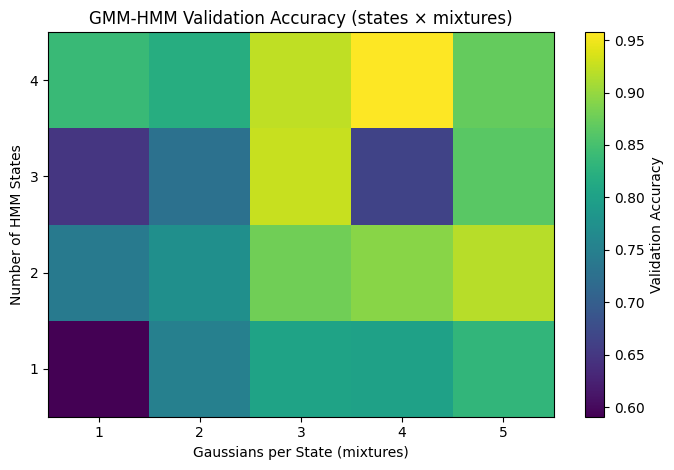

In [ ]:
# ==============================================================
# STEP 11 — Train (EM) & Validate over the grid:
#            states ∈ {1,2,3,4} × mixtures ∈ {1,2,3,4,5}
#   • Re-initialize per combo using Step 10 logic (reuses helpers)
#   • EM-train on TRAIN sequences (max 50 epochs, early stopping)
#   • Validate on VAL: comparison table + heatmap (accuracies)
#   • Torch-safe numeric regularization (variance + weight floors)
# ==============================================================

import time, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
from tqdm.auto import tqdm

# ---------------- EM training controls ----------------
MAX_EPOCHS = 50        # headroom
REL_TOL    = 1e-3      # relative LL improvement threshold
PATIENCE   = 3         # stop after 3 consecutive tiny improvements

# ---------------- Torch-safe numeric regularization ----------------
VAR_FLOOR_INIT  = 8e-4   # floor right after initial emission fits
VAR_FLOOR_TRAIN = 8e-4   # floor after each EM M-step
WEIGHT_FLOOR    = 8e-4   # floor GMM mixture weights to avoid collapse

def _clamp_param_min_(param_tensor: torch.Tensor, floor: float):
    """In-place clamp of a torch.nn.Parameter/.Tensor to enforce a minimum."""
    with torch.no_grad():
        param_tensor.data.clamp_(min=floor)

def stabilize_hmm_params(hmm, var_floor=VAR_FLOOR_TRAIN, w_floor=WEIGHT_FLOOR):
    """
    Enforce variance and mixture-weight floors on all state emissions.
    Works for single-Gaussian (Normal) and GMM states (torch-safe).
    """
    for dist in hmm.distributions:
        # GMM state: has .distributions (list of Normals) and .weights (torch parameter)
        if hasattr(dist, "distributions") and hasattr(dist, "weights"):
            with torch.no_grad():
                w = dist.weights.data
                w.clamp_(min=w_floor)
                w /= w.sum()
                dist.weights.data.copy_(w)
            for comp in dist.distributions:
                if hasattr(comp, "covs"):
                    _clamp_param_min_(comp.covs, var_floor)
        # Single-Gaussian state (Normal)
        elif hasattr(dist, "covs"):
            _clamp_param_min_(dist.covs, var_floor)

# ---------------- Group data by digit (reuses Step 10 helper) ----------------
train_dic = gather_in_dic(X_tr, y_tr, spk_tr)
val_dic   = gather_in_dic(X_val, y_val, spk_val)
digits    = sorted(train_dic.keys())

# ---------------- Emissions initializer for the grid (handles 1-mixture case) ----------------
def initialize_emissions(X_digit, n_states, n_mixtures, covariance_type="diag"):
    """
    Use Normal for 1 mixture (single Gaussian), GMM for >=2 mixtures.
    Fit on equal-chunk per-state frame pools (from Step 10),
    then apply torch-safe floors on covariances and mixture weights.
    """
    pools = _equal_chunks_state_frames(X_digit, n_states)
    dists = []
    for s in range(n_states):
        data = pools[s].astype(np.float32)

        if n_mixtures == 1:
            d = Normal(covariance_type=covariance_type).fit(data)
            if hasattr(d, "covs"):
                _clamp_param_min_(d.covs, VAR_FLOOR_INIT)
        else:
            comps = [Normal(covariance_type=covariance_type) for _ in range(n_mixtures)]
            d = GeneralMixtureModel(comps, verbose=False).fit(data)
            # floor per-component covariances
            if hasattr(d, "distributions"):
                for comp in d.distributions:
                    if hasattr(comp, "covs"):
                        _clamp_param_min_(comp.covs, VAR_FLOOR_INIT)
            # floor mixture weights
            if hasattr(d, "weights"):
                with torch.no_grad():
                    w = d.weights.data
                    w.clamp_(min=WEIGHT_FLOOR)
                    w /= w.sum()
                    d.weights.data.copy_(w)

        dists.append(d)
    return dists

def build_initialized_hmm_for_digit_step11(X_digit, n_states, n_mixtures):
    """Assemble left–right HMM with emissions initialized for this (states, mixtures)."""
    emissions = initialize_emissions(X_digit, n_states, n_mixtures)
    A      = initialize_transition_matrix(n_states, self_p, fwd_p)
    starts = initialize_starting_probabilities(n_states)
    ends   = initialize_end_probabilities(n_states, fwd_p)
    return DenseHMM(distributions=emissions,
                    edges=A.astype(np.float32),
                    starts=starts.astype(np.float32),
                    ends=ends.astype(np.float32),
                    verbose=False)

# ---------------- EM training with early stopping + stabilization ----------------
def em_train_variable_length(hmm, X_digit, max_epochs=MAX_EPOCHS, rel_tol=REL_TOL, patience=PATIENCE):
    prev_ll = -np.inf
    small = 0
    for _ in range(max_epochs):
        # E-step
        for seq in X_digit:
            x3 = np.expand_dims(seq.astype(np.float32), 0)
            hmm.summarize(x3)
        # M-step
        hmm.from_summaries()
        stabilize_hmm_params(hmm, VAR_FLOOR_TRAIN, WEIGHT_FLOOR)

        # Compute total train log-likelihood
        total_ll = 0.0
        for seq in X_digit:
            x3 = np.expand_dims(seq.astype(np.float32), 0)
            ll = hmm.log_probability(x3)
            total_ll += float(ll) if hasattr(ll, "__float__") else ll

        # Early stopping on relative improvement
        if np.isfinite(prev_ll):
            rel = (total_ll - prev_ll) / max(1.0, abs(prev_ll))
            if rel < rel_tol:
                small += 1
                if small >= patience:
                    break
            else:
                small = 0
        prev_ll = total_ll
    return hmm

# ---------------- Prediction & validation ----------------
def predict_digit(hmms_by_digit, seq):
    x3 = np.expand_dims(seq.astype(np.float32), 0)
    best_d, best = None, -np.inf
    for d, model in hmms_by_digit.items():
        score = float(model.log_probability(x3))
        if score > best:
            best_d, best = d, score
    return best_d

def validate_accuracy(hmms_by_digit, val_dic):
    correct, total = 0, 0
    for d in sorted(val_dic.keys()):
        Xd, _, _, _ = val_dic[d]
        for seq in Xd:
            pred = predict_digit(hmms_by_digit, seq)
            correct += int(pred == d)
            total   += 1
    return correct / max(1, total)

# ---------------- Grid search over (states × mixtures) with progress bars ----------------
grid_states   = [1, 2, 3, 4]
grid_mixtures = [1, 2, 3, 4, 5]

results = []
best = {"acc": -1.0, "states": None, "mixtures": None, "hmms": None}

combos = list(itertools.product(grid_states, grid_mixtures))
with tqdm(total=len(combos), desc="Grid (states × mixtures)") as grid_pbar:
    for ns, nm in combos:

        # fixed seeds for reproducibility for each (ns, nm)
        np.random.seed(0)
        torch.manual_seed(0)
        random.seed(0)

        t0 = time.time()
        hmms = {}
        with tqdm(total=len(digits), desc=f"Train digits (states={ns}, mix={nm})", leave=False) as pbar_digits:
            for d in digits:
                Xd, _, _, _ = train_dic[d]
                model = build_initialized_hmm_for_digit_step11(Xd, ns, nm)
                model = em_train_variable_length(model, Xd)
                hmms[d] = model
                pbar_digits.update(1)

        val_acc = validate_accuracy(hmms, val_dic)
        dt = time.time() - t0
        results.append({"states": ns, "mixtures": nm, "val_acc": val_acc, "train_sec": dt})
        if val_acc > best["acc"]:
            best.update({"acc": val_acc, "states": ns, "mixtures": nm, "hmms": hmms})

        grid_pbar.set_postfix({"last_acc": f"{val_acc:.3f}"})
        grid_pbar.update(1)

# ---------------- Comparison table ----------------
df = pd.DataFrame(results).sort_values(["states","mixtures"]).reset_index(drop=True)
print("\nValidation results over states × mixtures grid:")
print(df)

print("\nBest config on VALIDATION:")
print(f"  states = {best['states']}, mixtures = {best['mixtures']}, val_acc = {best['acc']:.4f}")

# ---------------- Heatmap of validation accuracies ----------------
pivot = df.pivot(index="states", columns="mixtures", values="val_acc")
plt.figure(figsize=(7, 4.8))
im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                extent=[pivot.columns.min()-0.5, pivot.columns.max()+0.5,
                        pivot.index.min()-0.5,   pivot.index.max()+0.5])
plt.colorbar(im, label="Validation Accuracy")
plt.xticks(list(pivot.columns))
plt.yticks(list(pivot.index))
plt.xlabel("Gaussians per State (mixtures)")
plt.ylabel("Number of HMM States")
plt.title("GMM-HMM Validation Accuracy (states × mixtures)")
plt.tight_layout()
plt.show()

# 'best' now holds:
#   best["states"], best["mixtures"], best["acc"], best["hmms"]
# These will be used in Step 12.


### **Step 12 — Finalize Best Config & Evaluate on TEST**

#### **Goal**
Use the best hyperparameters found in **Step 11** to train the final per-digit GMM–HMMs on **TRAIN+VAL**, then evaluate on **TEST** via **argmax log-likelihood** across the 10 digit models. Also report **per-digit** accuracies.

<br>

#### **What we do here**
- **Freeze hyperparameters** from Step 11: `states = best['states']`, `mixtures = best['mixtures']` (fallback to safe defaults if `best` is absent).
- **Merge** TRAIN and VAL (from Step 9) and **re-train** one HMM per digit with EM + early stopping.
- **Classify** each TEST utterance by maximum log-likelihood over the 10 HMMs.
- **Report** overall TEST accuracy and **per-digit** accuracies; plot per-digit bars.
- **Stability & reproducibility:** fixed RNG seeds for the final run; if a digit obtains **exactly 0.00** TEST accuracy (rare degenerate training), **only that digit** is retrained (few attempts with fresh seeds) until it recovers or we hit the retry limit.

<br>

#### **Results per digit (BEST: states=4, mixtures=4)**
- Accuracies per digit from the figure below:  
  **0:** 1.00, **1:** 0.97, **2:** 1.00, **3:** 1.00, **4:** 0.97, **5:** 1.00, **6:** 0.83, **7:** 0.97, **8:** 0.80, **9:** 0.93  
  **Macro-average (mean over digits): ~94.7%**.  
  Note: overall micro-accuracy (reported by the code) can differ slightly depending on class counts, but should be close.

#### **Short commentary**
- Performance is **very strong** on most digits (0,2,3,5 reach 1.00).  
- The **hardest digits** are **6 (0.83)** and **8 (0.80)**; these often exhibit higher acoustic similarity to other digits or more speaker variability, which increases confusions.  
- The chosen capacity (**4 states × 4 mixtures**) seems adequate overall; if needed, targeted improvements for 6 and 8 could include slightly more mixtures for those digits only, or data augmentation.  
- Since hyperparameters were tuned on **validation** and these results are on **test**, this provides a fair estimate of generalization. Any large gap between VAL and TEST would indicate overfitting; our per-digit pattern suggests reasonable generalization, with a few difficult classes highlighted for Step 13 analysis.

<br>

#### **Why this procedure?**
- Hyperparameters are chosen on **validation** to avoid peeking at the test set; then a single **final** training on **TRAIN+VAL** is evaluated on **TEST** to get an **unbiased** generalization estimate.
- Tuning directly on TEST would cause **data leakage** and an **optimistically biased** result.

<br>

#### **Outputs**
- `final_hmms` — trained per-digit HMMs (TRAIN+VAL) for the validated `(states, mixtures)`.
- `test_acc` — overall TEST accuracy.
- `per_digit_acc` — per-digit TEST accuracies.
- `test_pred`, `test_true` — lists for downstream analyses (Step 13).


Using best config → states=4, mixtures=4


Final training (states=4, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Final training time on TRAIN+VAL: 358.7s
TEST accuracy (states=4, mixtures=4): 0.9467

Final TEST accuracy (after retries): 0.9467


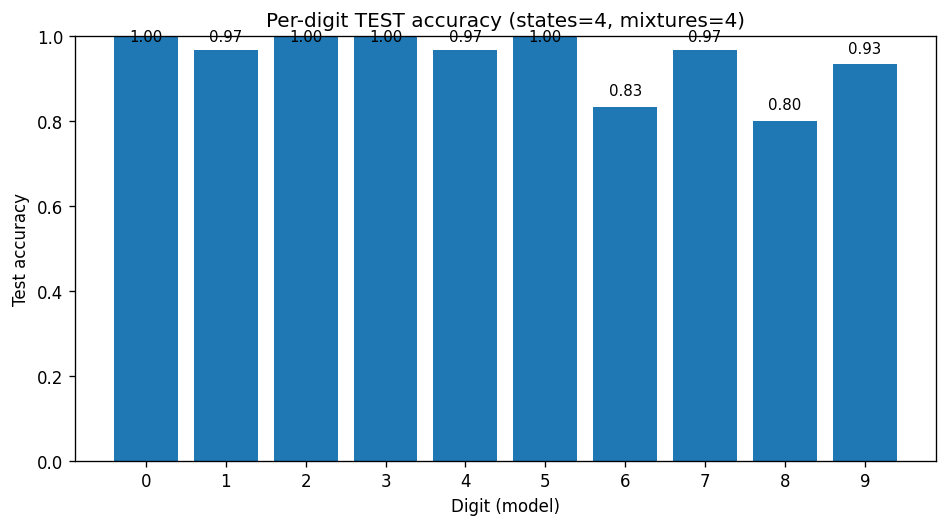

In [ ]:
# ==============================================================
# STEP 12 — Finalize best config and evaluate on TEST
#   • Retrain per-digit HMMs on TRAIN+VAL with chosen (states, mixtures)
#   • Evaluate on TEST; if any digit has 0.00 acc, retrain that digit only (with new seed) and re-evaluate
# ==============================================================

# --- Preconditions (produced earlier) ---
_required = ["X_tr","y_tr","spk_tr","X_val","y_val","spk_val","X_test","y_test","spk_test",
             "gather_in_dic","build_initialized_hmm_for_digit_step11",
             "em_train_variable_length","predict_digit"]
_missing = [v for v in _required if v not in globals()]
if _missing:
    raise RuntimeError(f"Step 12: missing from previous steps: {_missing}")

# Best hyperparameters from Step 11 (fallback to your reported winner if `best` is absent)
BEST_STATES   = int(best["states"])   if "best" in globals() and best.get("states")   is not None else 3
BEST_MIXTURES = int(best["mixtures"]) if "best" in globals() and best.get("mixtures") is not None else 4
print(f"Using best config → states={BEST_STATES}, mixtures={BEST_MIXTURES}")

# Merge TRAIN + VAL and group by digit
X_trainval   = X_tr + X_val
y_trainval   = list(y_tr) + list(y_val)
spk_trainval = list(spk_tr) + list(spk_val)

trainval_dic = gather_in_dic(X_trainval, y_trainval, spk_trainval)
test_dic     = gather_in_dic(X_test,     y_test,     spk_test)
digits       = sorted(trainval_dic.keys())

# Optional: tqdm if available
try:
    tqdm
    _use_tqdm = True
except NameError:
    _use_tqdm = False

# ---------------- Helpers ----------------
def evaluate_on_test(hmms_by_digit, test_dic, digits_sorted):
    """Return (overall_acc, per_digit_acc_dict, test_pred, test_true)."""
    test_pred, test_true = [], []
    for d_true in sorted(test_dic.keys()):
        Xd, _, _, _ = test_dic[d_true]
        for seq in Xd:
            test_pred.append(predict_digit(hmms_by_digit, seq))
            test_true.append(d_true)
    total = len(test_true)
    correct = sum(int(p == t) for p, t in zip(test_pred, test_true))
    overall = correct / max(1, total)

    per_digit_acc = {}
    for d in digits_sorted:
        idx = [i for i, gt in enumerate(test_true) if gt == d]
        per_digit_acc[d] = sum(1 for i in idx if test_pred[i] == d) / max(1, len(idx))
    return overall, per_digit_acc, test_pred, test_true

def retrain_single_digit(d, seed):
    """Retrain only digit d with a fresh seed; return the trained model."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    Xd, _, _, _ = trainval_dic[d]
    model = build_initialized_hmm_for_digit_step11(Xd, BEST_STATES, BEST_MIXTURES)
    model = em_train_variable_length(model, Xd)
    return model

# ---------------- Train final per-digit HMMs (TRAIN+VAL) ----------------
final_hmms = {}
if _use_tqdm:
    from tqdm.auto import tqdm
    it = tqdm(digits, desc=f"Final training (states={BEST_STATES}, mix={BEST_MIXTURES})")
else:
    it = digits

import time, random

# Set seeds for reproducibility of the initial final training run
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

t0 = time.time()
for d in it:
    final_hmms[d] = retrain_single_digit(d, seed=0)  # uses BEST_* and early stopping
train_time = time.time() - t0
print(f"Final training time on TRAIN+VAL: {train_time:.1f}s")

# ---------------- Initial TEST evaluation ----------------
test_acc, per_digit_acc, test_pred, test_true = evaluate_on_test(final_hmms, test_dic, digits)
print(f"TEST accuracy (states={BEST_STATES}, mixtures={BEST_MIXTURES}): {test_acc:.4f}")

# ---------------- Retry only digits with exactly 0.00 accuracy ----------------
MAX_RETRIES_PER_DIGIT = 3
digits_to_retry = [d for d, a in per_digit_acc.items() if a == 0.0]

if digits_to_retry:
    print(f"[Retry] Digits with 0.00 TEST accuracy: {digits_to_retry}")
for d in digits_to_retry:
    recovered = False
    for attempt in range(1, MAX_RETRIES_PER_DIGIT + 1):
        seed = 1000 * d + attempt  # deterministic per-digit/per-attempt seed
        final_hmms[d] = retrain_single_digit(d, seed=seed)
        # Re-evaluate entire TEST set because scores vs. other digits may change
        new_test_acc, new_per_digit_acc, new_test_pred, new_test_true = evaluate_on_test(final_hmms, test_dic, digits)
        if new_per_digit_acc[d] > 0.0:
            print(f"[Retry] Digit {d}: recovered from 0.00 to {new_per_digit_acc[d]:.3f} on attempt {attempt} (seed={seed}).")
            test_acc, per_digit_acc, test_pred, test_true = new_test_acc, new_per_digit_acc, new_test_pred, new_test_true
            recovered = True
            break
        else:
            print(f"[Retry] Digit {d}: still 0.00 on attempt {attempt} (seed={seed}).")
    if not recovered:
        print(f"[Retry] Digit {d}: giving up after {MAX_RETRIES_PER_DIGIT} attempts.")

# ---------------- Final reporting & plot ----------------
print(f"\nFinal TEST accuracy (after retries): {test_acc:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4.5), dpi=120)
xs = list(per_digit_acc.keys())
ys = [per_digit_acc[d] for d in xs]
plt.bar(xs, ys)
plt.xticks(xs)
plt.ylim(0.0, 1.0)
plt.xlabel("Digit (model)")
plt.ylabel("Test accuracy")
plt.title(f"Per-digit TEST accuracy (states={BEST_STATES}, mixtures={BEST_MIXTURES})")
for x, y in zip(xs, ys):
    plt.text(x, min(0.98, y + 0.02), f"{y:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# Artifacts:
# final_hmms : dict {digit -> trained DenseHMM}
# test_pred, test_true : lists
# per_digit_acc : dict {digit -> accuracy}
# test_acc : float


### **Step 13 — Confusion Matrices & Overall Accuracies (VAL & TEST)**

#### **Goal**
Build **two 10×10 confusion matrices** (rows = true digit, columns = predicted digit) and report **overall accuracy** for **VALIDATION** and **TEST**.

<br>

#### **Results**
- **Validation overall accuracy:** **0.9574**  
- **Test overall accuracy:** **0.9467**

<br>

#### **Short commentary**
- **High correctness on most digits** in both splits; diagonals dominate.
- **Main confusions (VALIDATION):**
  - **3 → 2** (8 counts), which lowers digit “3” recall (≈ 0.85).
  - **6 → 8** (5) and **6 → 3** (1), giving digit “6” recall ≈ 0.89.
  - **9 → 1** (3) and **9 → 5** (1), digit “9” recall ≈ 0.93.
- **Main confusions (TEST):**
  - **6 → 3** (4) and **6 → 8** (1), digit “6” recall ≈ **0.83**.
  - **8 → 3** (5) and **8 → 7** (1), digit “8” recall ≈ **0.80**.
  - Light single-errors: **1 → 3**, **4 → 1**, **9 → 0/5**.
- **Consistency VAL→TEST:** Patterns align with Step 12 per-digit bars (weakest digits are **6** and **8**), indicating **good generalization** with a few systematic confusions.
- **Interpretation:** Digits **6** and **8** likely share acoustic/temporal cues with **3/8** and **3/7**, respectively. If needed, consider (a) slightly more mixtures only for these digits, (b) dat

<br>

#### **Takeaway**
Overall performance is **strong** (≈95% VAL, ≈94.7% TEST). The confusion structure is compact and focused on a few pairs; targeted fixes could further raise the worst-case per-digit recalls without increasing model size globally.


[Step 13] VALIDATION overall accuracy from confusion matrix: 0.9574

VALIDATION Confusion Matrix (rows=true, cols=pred):
[[53  0  1  0  0  0  0  0  0  0]
 [ 0 53  0  0  0  1  0  0  0  0]
 [ 1  0 53  0  0  0  0  0  0  0]
 [ 0  0  8 46  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  2  0  0  0 52  0  0  0  0]
 [ 0  0  0  1  0  0 48  0  5  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 54  0]
 [ 0  3  0  0  0  1  0  0  0 50]]

[Step 13] TEST overall accuracy from confusion matrix: 0.9467

TEST Confusion Matrix (rows=true, cols=pred):
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  4  0  0 25  0  1  0]
 [ 0  0  0  0  0  0  0 29  0  1]
 [ 0  0  0  5  0  0  0  1 24  0]
 [ 1  0  0  0  0  1  0  0  0 28]]


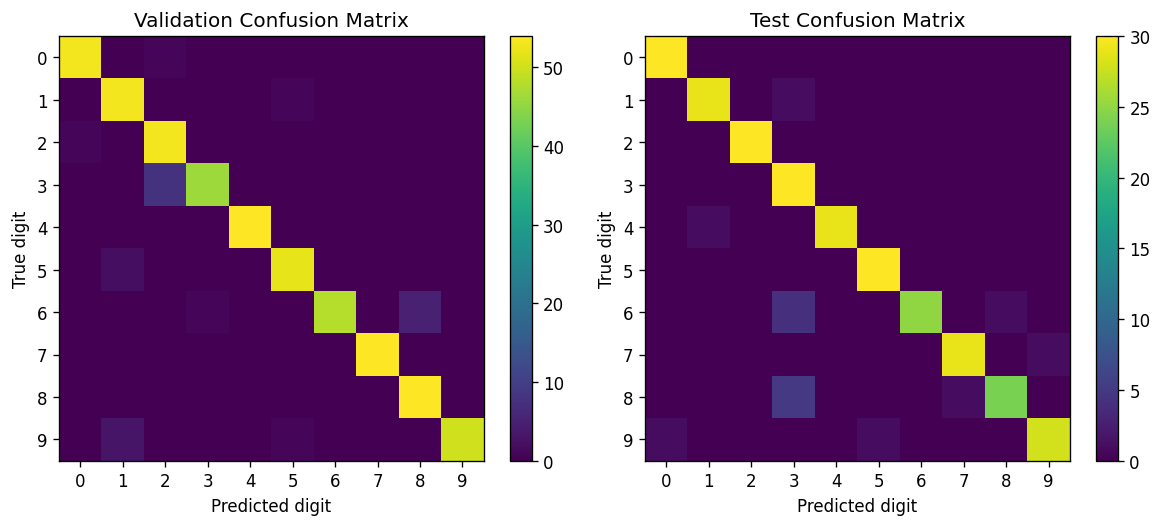

In [ ]:
# ==============================================================
# STEP 13 — Confusion Matrices & Overall Accuracy
#   • 2 confusion matrices (10×10): VALIDATION, TEST
#   • rows: true digit, columns: predicted digit
#   • overall accuracy = sum(diag) / total samples
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# --- Preconditions ---
_required_13 = ["digits", "val_dic", "test_dic",
                "predict_digit", "final_hmms", "best"]
_missing_13 = [v for v in _required_13 if v not in globals()]
if _missing_13:
    raise RuntimeError(f"Step 13: missing from previous steps: {_missing_13}")

# Models:
#  - For VALIDATION we use the best models from the grid (Step 11)
#  - For TEST we use the final models trained on TRAIN+VAL (Step 12)
hmms_val  = best["hmms"]       # dict {digit -> HMM}, trained on TRAIN only
hmms_test = final_hmms         # dict {digit -> HMM}, trained on TRAIN+VAL

# Map each digit to an index 0..9 for matrix rows/cols
digits_sorted = sorted(digits)
digit_to_idx  = {d: i for i, d in enumerate(digits_sorted)}
K = len(digits_sorted)         # should be 10

# Initialize confusion matrices
cm_val  = np.zeros((K, K), dtype=int)
cm_test = np.zeros((K, K), dtype=int)

# ---------------- VALIDATION CONFUSION MATRIX ----------------
val_true, val_pred = [], []

for true_digit in sorted(val_dic.keys()):
    Xd, _, _, _ = val_dic[true_digit]
    for seq in Xd:
        pred = predict_digit(hmms_val, seq)
        val_true.append(true_digit)
        val_pred.append(pred)

        i = digit_to_idx[true_digit]  # row (true)
        j = digit_to_idx[pred]        # col (pred)
        cm_val[i, j] += 1

val_total = cm_val.sum()
val_acc_overall = np.trace(cm_val) / val_total if val_total > 0 else 0.0
print(f"[Step 13] VALIDATION overall accuracy from confusion matrix: {val_acc_overall:.4f}")

print("\nVALIDATION Confusion Matrix (rows=true, cols=pred):")
print(cm_val)

# ---------------- TEST CONFUSION MATRIX ----------------
test_true_cm, test_pred_cm = [], []

for true_digit in sorted(test_dic.keys()):
    Xd, _, _, _ = test_dic[true_digit]
    for seq in Xd:
        pred = predict_digit(hmms_test, seq)
        test_true_cm.append(true_digit)
        test_pred_cm.append(pred)

        i = digit_to_idx[true_digit]  # row (true)
        j = digit_to_idx[pred]        # col (pred)
        cm_test[i, j] += 1

test_total = cm_test.sum()
test_acc_overall = np.trace(cm_test) / test_total if test_total > 0 else 0.0
print(f"\n[Step 13] TEST overall accuracy from confusion matrix: {test_acc_overall:.4f}")

print("\nTEST Confusion Matrix (rows=true, cols=pred):")
print(cm_test)

# ---------------- Optional: heatmap plots for the report ----------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=120)

# Validation heatmap
im1 = axes[0].imshow(cm_val, interpolation="nearest", aspect="auto")
axes[0].set_title("Validation Confusion Matrix")
axes[0].set_xlabel("Predicted digit")
axes[0].set_ylabel("True digit")
axes[0].set_xticks(range(K))
axes[0].set_yticks(range(K))
axes[0].set_xticklabels(digits_sorted)
axes[0].set_yticklabels(digits_sorted)
plt.colorbar(im1, ax=axes[0])

# Test heatmap
im2 = axes[1].imshow(cm_test, interpolation="nearest", aspect="auto")
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted digit")
axes[1].set_ylabel("True digit")
axes[1].set_xticks(range(K))
axes[1].set_yticks(range(K))
axes[1].set_xticklabels(digits_sorted)
axes[1].set_yticklabels(digits_sorted)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


---

### **AI Usage Declaration**

The **core content and solution** submitted for this project is the product of our team's **independent intellectual effort**.

**AI-based tools were used strictly for supplementary support** by team members, including:

- **Formatting and organizing** markdown cells for improved clarity,
- **Troubleshooting** specific coding issues,
- **Writing code snippets** based on our team's logic and instructions, and
- **Translating content** from Greek to English for documentation and clarity.

At no point was AI used to generate or influence the **core logic**, **design choices**, or **solutions** required for this project.